In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import statistics as stat
from scipy import stats
from scipy.optimize import curve_fit
from tqdm import tqdm
from collections import defaultdict
from matplotlib.collections import LineCollection

## Main algorithm

In [5]:
# Constants
DIRECTIONS = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # Right, Left, Down, Up

def initialize_system(L):
    """Initialize bond configuration and worm positions"""
    bonds = np.zeros((L, L, 4), dtype=int)  # LxL grid, 4 directions per site
    x0, y0 = random.randint(0, L-1), random.randint(0, L-1)  # Worm head/tail
    return bonds, (x0, y0), (x0, y0)

def get_opposite_dir(dir_index):
    """Get opposite direction index using bitwise XOR"""
    return dir_index ^ 1

def move_worm(x, y, bonds, beta, L, stats):
    """Perform one worm move with detailed balance"""
    while True:  # Keep trying until move is accepted
        dir_index = random.randint(0, 3)
        dx, dy = DIRECTIONS[dir_index]
        x_new, y_new = (x + dx) % L, (y + dy) % L
        opp_dir = get_opposite_dir(dir_index)
        
        # Determine if we're adding or removing a bond
        bond_change = 1 if bonds[x, y, dir_index] == 0 else -1
        

        # Bond acceptance
        if bond_change == 1:
            p_accept = math.tanh(beta)
            stats['attempts'] += 1
        else:
            p_accept = 1.0  # Always accept bond deletion

        if random.random() < p_accept:
            bonds[x, y, dir_index] ^= 1  # Flip current bond
            bonds[x_new, y_new, opp_dir] ^= 1  # Flip reciprocal bond
            if bond_change == 1:
                stats['acceptances'] += 1
            return x_new, y_new

def calculate_shell_degeneracy(L):
    """Calculate multiplicity of distances on periodic lattice"""
    degeneracy = defaultdict(int)
    for dx in range(-L//2 + 1, L//2 + 1):
        for dy in range(-L//2 + 1, L//2 + 1):
            r2 = dx**2 + dy**2
            degeneracy[r2] += 1
    return degeneracy

def run_worm_algorithm(L, T, n_worms, steps_per_worm, thermalization=1000, sample_interval=10):
    """Main simulation function with robust normalization"""
    beta = 1.0 / T
    bonds, I, M = initialize_system(L)
    G_r = defaultdict(float)
    G0 = 0 #Z-sector: closed loops count
    path_history = []
    energy_history = []
    stats = {'attempts': 0, 'acceptances': 0}
    
    # Thermalization
    for _ in range(thermalization):
        M = move_worm(*M, bonds, beta, L, stats)
        if M == I:
            I = (random.randint(0, L-1), random.randint(0, L-1))
            M = I
    
    # Measurement
    for worm in range(n_worms):
        I = (random.randint(0, L-1), random.randint(0, L-1))
        M = I
        worm_path = [I]
        if worm % sample_interval == 0:
            energy = calculate_energy(bonds, L, T)
            energy_history.append(energy)
        
        for _ in range(steps_per_worm):
            M = move_worm(*M, bonds, beta, L, stats)
            worm_path.append(M)

            dx = min((M[0] - I[0]) % L, (I[0] - M[0]) % L)
            dy = min((M[1] - I[1]) % L, (I[1] - M[1]) % L)
            r2 = dx**2 + dy**2

            G_r[r2] += 1
            
            if M == I and len(worm_path) > 1:
                G0 += 1
                break  # Closed loop found, stop this worm
        
        path_history.append(worm_path)
    
    # SAFE Normalization
    degeneracy = calculate_shell_degeneracy(L)
    normalized_G = {}
    
    if G0 > 0:
        for r in G_r:
            if degeneracy.get(r, 0) > 0:  # Check both G0 and degeneracy
                normalized_G[r] = G_r[r] / (G0 * degeneracy[r])
            else:
                normalized_G[r] = 0.0
    else:
        print(f"Warning: No closed loops formed in {n_worms} worms")
        print(f"Try increasing steps_per_worm (current: {steps_per_worm})")
        for r in G_r:
            normalized_G[r] = 0.0
    
    # calculate acceptance rate
    stats['empirical_rate'] = stats['acceptances'] / stats['attempts']
    stats['expected_rate'] = math.tanh(beta)

    return {
        'G_r': G_r,
        'bonds': bonds,
        'path_history': path_history,
        'G0': G0,
        'energy_history': energy_history,  # New: Energy samples
        'stats': stats
    }

In [ ]:
# Simulation parameters (adjusted for better results)
L = 20
T = 2.27  # Critical temperature for 2D Ising
n_worms = 5000  # Reduced for faster testing
steps_per_worm = 2000  # Increased chance of closing
sample_interval = 10  # Sample every 10 worms for energy

# Run simulation
result = run_worm_algorithm(L, T, n_worms, steps_per_worm)

### Testing Probability Accuracy

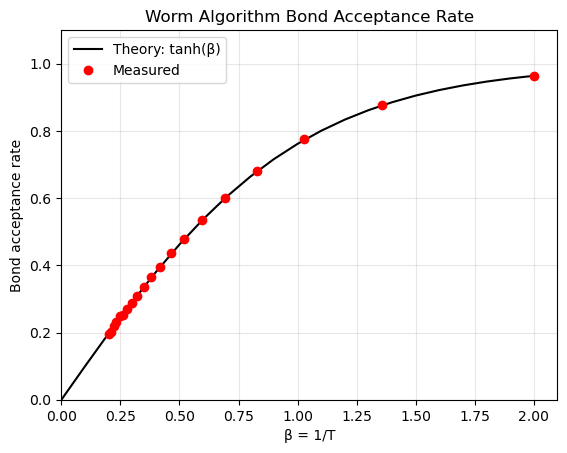

In [ ]:
# Test temperatures
T_values = np.linspace(0.5, 5.0, 20)
beta_values = 1.0 / T_values
empirical_rates = []
expected_rates = []

for T in T_values:
    stats = run_worm_algorithm(L=32, T=T, n_worms=1000, steps_per_worm=100)['stats']
    empirical_rates.append(stats['empirical_rate'])

for beta in np.arange(0, 2.1, 0.1):
    expected_rates.append(np.tanh(beta))

# Plot
plt.plot(np.arange(0, 2.1, 0.1), expected_rates, 'k-', label='Theory: tanh(β)')
plt.plot(beta_values, empirical_rates, 'ro', label='Measured')
plt.xlabel('β = 1/T')
plt.ylabel('Bond acceptance rate')
plt.xlim(0, 2.1)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(alpha=0.3)
plt.title("Worm Algorithm Bond Acceptance Rate")
plt.show()

## Spin-spin Correlation

In [ ]:
# Simulation parameters
L = 64
n_worms = 10000
steps_per_worm = 10000
temperatures = [1.0, 1.5, 2.269, 2.5, 2.7, 3.0]  # Below Tc, At Tc, Above Tc

# Run simulations and plot
corr_data_64 = []
for T in temperatures:
    G_r = run_worm_algorithm(L, T, n_worms, steps_per_worm)['G_r']
    
    # Convert to arrays for plotting
    r = np.sqrt(np.array(list(G_r.keys())))
    g = np.array(list(G_r.values()))
    
    # Sort by r
    sort_idx = np.argsort(r)
    r = r[sort_idx]
    g = g[sort_idx]
    corr_data_64.append((T, r, g))

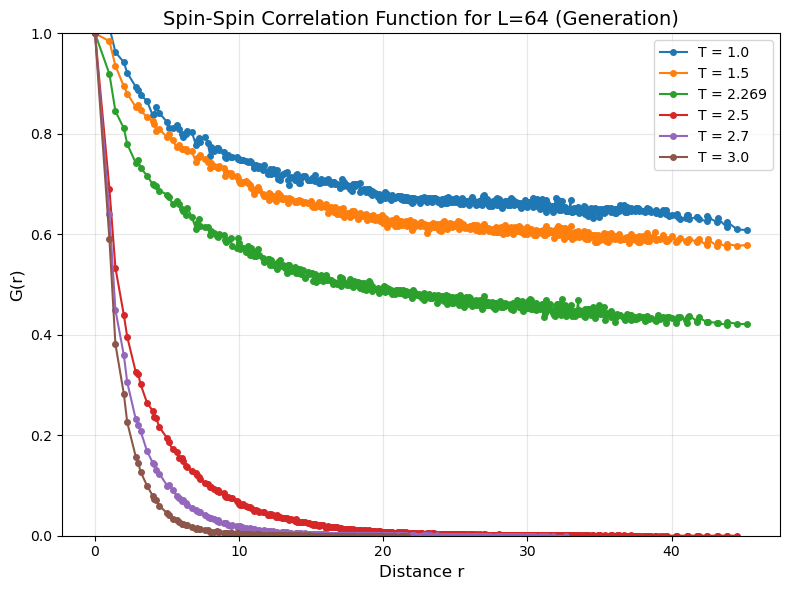

In [171]:
# Plot G(r) vs r
plt.figure(figsize=(8, 6))    

for data in corr_data_64:
    T, r, g = data
    plt.plot(r, g, 'o-', label=f'T = {T}', markersize=4)

plt.xlabel('Distance r', fontsize=12)
plt.ylabel('G(r)', fontsize=12)
plt.title(f'Spin-Spin Correlation Function for L=64 (Generation)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Add theoretical predictions
r_theory = np.linspace(1, L//2, 100)
#plt.plot(r_theory, r_theory**(-1/4), 'k--', label='Theory at Tc (r$^{-1/4}$)')

#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0, L//2)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Simulation parameters
L = 32
n_worms = 5000
steps_per_worm = 5000
temperatures = [1.0, 1.5, 2.269, 2.5, 2.7, 3.0]  # Below Tc, At Tc, Above Tc

# Run simulations and plot
corr_data_32_new = []
for T in temperatures:
    G_r = run_worm_algorithm(L, T, n_worms, steps_per_worm)['G_r']
    
    # Convert to arrays for plotting
    r = np.sqrt(np.array(list(G_r.keys())))
    g = np.array(list(G_r.values()))
    
    # Sort by r
    sort_idx = np.argsort(r)
    r = r[sort_idx]
    g = g[sort_idx]
    corr_data_32_new.append((T, r, g))

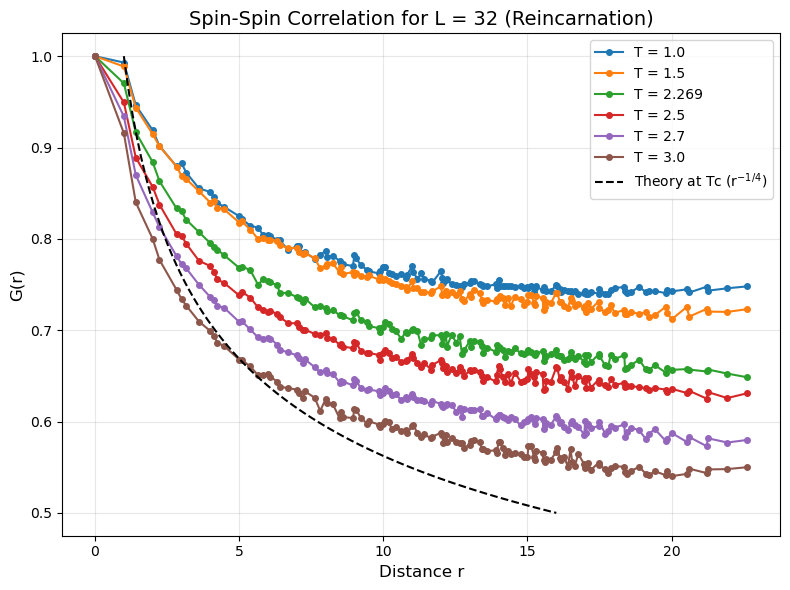

In [163]:
# Plot G(r) vs r
plt.figure(figsize=(8, 6))    

for data in corr_data_32_new:
    T, r, g = data
    plt.plot(r, g, 'o-', label=f'T = {T}', markersize=4)

plt.xlabel('Distance r', fontsize=12)
plt.ylabel('G(r)', fontsize=12)
plt.title(f'Spin-Spin Correlation for L = {L} (Reincarnation)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Add theoretical predictions
r_theory = np.linspace(1, L//2, 100)
plt.plot(r_theory, r_theory**(-1/4), 'k--', label='Theory at Tc (r$^{-1/4}$)')

#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0, L//2)
#plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Simulation parameters
L = 32
n_worms = 5000
steps_per_worm = 5000
temperatures = [1.0, 1.5, 2.269, 2.5, 2.7, 3.0]  # Below Tc, At Tc, Above Tc

# Run simulations and plot
corr_data_32 = []
for T in temperatures:
    G_r = run_worm_algorithm(L, T, n_worms, steps_per_worm)['G_r']
    
    # Convert to arrays for plotting
    r = np.sqrt(np.array(list(G_r.keys())))
    g = np.array(list(G_r.values()))
    
    # Sort by r
    sort_idx = np.argsort(r)
    r = r[sort_idx]
    g = g[sort_idx]
    corr_data_32.append((T, r, g))

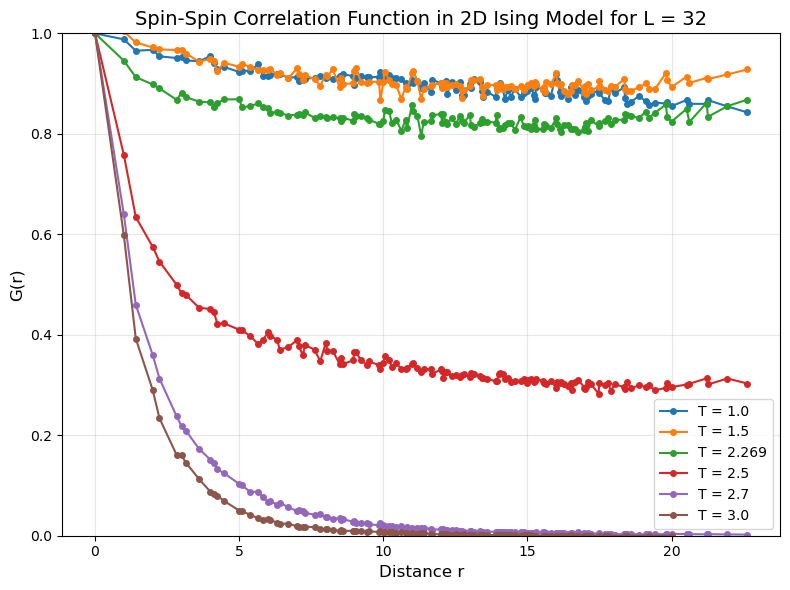

In [116]:
# Plot G(r) vs r
plt.figure(figsize=(8, 6))    

for data in corr_data_32:
    T, r, g = data
    plt.plot(r, g, 'o-', label=f'T = {T}', markersize=4)

plt.xlabel('Distance r', fontsize=12)
plt.ylabel('G(r)', fontsize=12)
plt.title(f'Spin-Spin Correlation Function in 2D Ising Model for L = {L}', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Add theoretical predictions
r_theory = np.linspace(1, L//2, 100)
#plt.plot(r_theory, r_theory**(-1/4), 'k--', label='Theory at Tc (r$^{-1/4}$)')

#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0, L//2)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Simulation parameters
L = 32
n_worms = 10000
steps_per_worm = 10000
temperatures = [1.0, 1.5, 2.2, 2.269, 2.3,  2.7, 3.0]  # Below Tc, At Tc, Above Tc

# Run simulations and plot
corr_data_32 = []
for T in temperatures:
    G_r = run_worm_algorithm(L, T, n_worms, steps_per_worm)['G_r']
    
    # Convert to arrays for plotting
    r = np.sqrt(np.array(list(G_r.keys())))
    g = np.array(list(G_r.values()))
    
    # Sort by r
    sort_idx = np.argsort(r)
    r = r[sort_idx]
    g = g[sort_idx]
    corr_data_32.append((T, r, g))

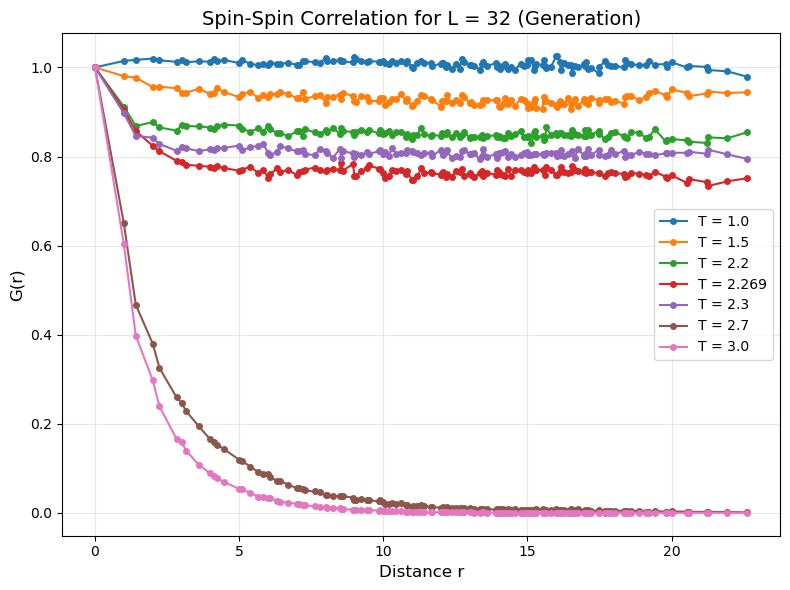

In [164]:
# Plot G(r) vs r
plt.figure(figsize=(8, 6))    

for data in corr_data_32:
    T, r, g = data
    plt.plot(r, g, 'o-', label=f'T = {T}', markersize=4)

plt.xlabel('Distance r', fontsize=12)
plt.ylabel('G(r)', fontsize=12)
plt.title(f'Spin-Spin Correlation for L = {L} (Generation)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Add theoretical predictions
r_theory = np.linspace(1, L//2, 100)
#plt.plot(r_theory, r_theory**(-1/4), 'k--', label='Theory at Tc (r$^{-1/4}$)')

#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0, L//2)
#plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

## Observables

In [7]:
n_worms = 5000
steps_per_worm = 5000
T_range = np.linspace(0.5, 5.0, 50)  # Below Tc, At Tc, Above Tc
L_range = [8, 16, 32]  # Different lattice sizes
# Run simulations for different lattice sizes and temperatures
results = {}

for L in L_range:
    results[L] = {}
    for T in tqdm(T_range, desc=f"L = {L}"):
        result = run_worm_algorithm(L, T, n_worms, steps_per_worm)        
        results[L][T] = result

L = 8:   0%|          | 0/50 [00:00<?, ?it/s]

L = 32: 100%|██████████| 50/50 [08:25<00:00, 10.11s/it]


In [22]:
L=64
results[L] = {}
for T in tqdm(T_range[:25], desc=f"L = {L}"):
    result = run_worm_algorithm(L, T, n_worms, steps_per_worm)        
    results[L][T] = result

L = 64:  76%|███████▌  | 19/25 [10:12<03:05, 30.88s/it]

In [23]:
for T in tqdm(T_range[25:], desc=f"L = {L}"):
    result = run_worm_algorithm(L, T, n_worms, steps_per_worm)        
    results[L][T] = result

L = 64: 100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


### Energy

In [43]:
def calculate_energy(bonds, L, T):
    """Calculate average energy per site"""
    beta = 1.0 / T
    total_bonds = 2 * L * L  # 2 bonds per site (since 4 directions but each bond shared)
    occupied_bonds = np.sum(bonds) // 2  # Divide by 2 because each bond is counted twice
    empty_bonds = total_bonds - occupied_bonds
    energy_per_bond = - (occupied_bonds - empty_bonds * np.tanh(beta))
    return energy_per_bond / (L * L)  # Energy per site

In [ ]:
def calculate_energy_2(bonds, L, T):
    #Count total number of occupied bonds
    N_b = np.sum(bonds) // 2  #each bond counted twice (once from each site)

    #average energy using formula
    energy = -np.tanh(1/T) * (2 * L**2 + N_b / (np.sinh(1/T)**2))
    return energy / L**2  # return per-site energy

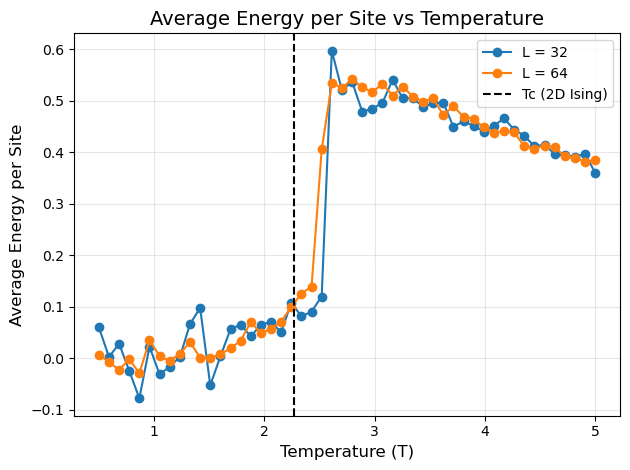

In [44]:
# Calculate energy
L_range = [8, 16, 32, 64]
energy_results = {}
for L in L_range:
    energy_results[L] = []
    for T in T_range:
        result = results[L][T]
        energy = calculate_energy(result['bonds'], L, T)
        
        energy_results[L].append(energy)

# Plot energy vs temperature
#plt.figure(figsize=(10, 6))
for L in L_range[2:]:
    plt.plot(T_range, energy_results[L], marker='o', label=f'L = {L}')

plt.axvline(x=2.269, color='k', linestyle='--', label='Tc (2D Ising)')
plt.xlabel('Temperature (T)', fontsize=12)
plt.ylabel('Average Energy per Site', fontsize=12)
plt.title('Average Energy per Site vs Temperature', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

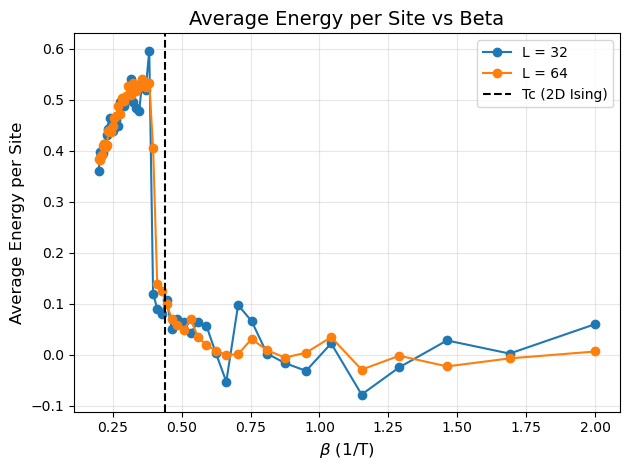

In [45]:
# Calculate energy
L_range = [8, 16, 32, 64]
energy_results = {}
for L in L_range:
    energy_results[L] = []
    for T in T_range:
        result = results[L][T]
        energy = calculate_energy(result['bonds'], L, T)
        
        energy_results[L].append(energy)

# Plot energy vs temperature
#plt.figure(figsize=(10, 6))
beta_range = 1/T_range
for L in L_range[2:]:
    plt.plot(beta_range, energy_results[L], marker='o', label=f'L = {L}')

plt.axvline(x=1/2.269, color='k', linestyle='--', label='Tc (2D Ising)')
plt.xlabel(r'$\beta$ (1/T)', fontsize=12)
plt.ylabel('Average Energy per Site', fontsize=12)
plt.title('Average Energy per Site vs Beta', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Specific Heat

In [57]:

def calculate_specific_heat(energy_history, L, T):
    """Calculate specific heat from energy fluctuations"""
    if len(energy_history) < 2:
        return 0.0
    mean_e = np.mean(energy_history)
    mean_e2 = np.mean([e*e for e in energy_history])
    return (mean_e2 - mean_e**2) / (T**2)

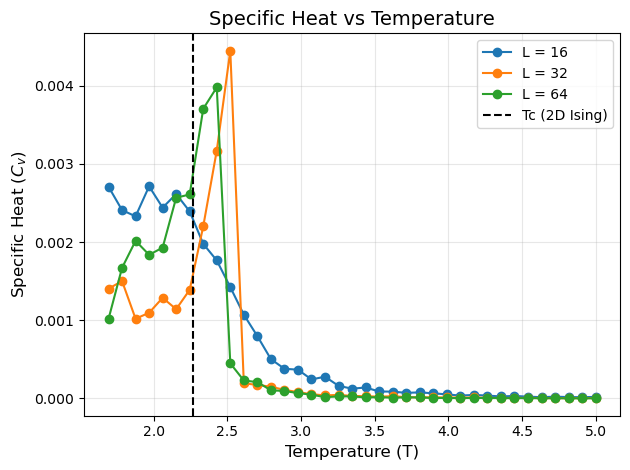

In [157]:
# Specific heat calculation
specific_heat = {}
for L in L_range:
    specific_heat[L] = []
    for T in T_range:
        result = results[L][T]
        energy_history = result['energy_history']
        if len(energy_history) > 10:
            cv = calculate_specific_heat(energy_history, L, T)
        else:
            cv = 0.0
        specific_heat[L].append(cv)

# Plot specific heat vs temperature
#plt.figure(figsize=(10, 6))
beta_range = 1/T_range
for L in L_range[1:]:
    plt.plot(T_range[13:], specific_heat[L][13:], marker='o', label=f'L = {L}')

plt.axvline(x=2.269, color='k', linestyle='--', label='Tc (2D Ising)')
plt.xlabel('Temperature (T)', fontsize=12)
plt.ylabel(r'Specific Heat ($C_v$)', fontsize=12)
plt.title('Specific Heat vs Temperature', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

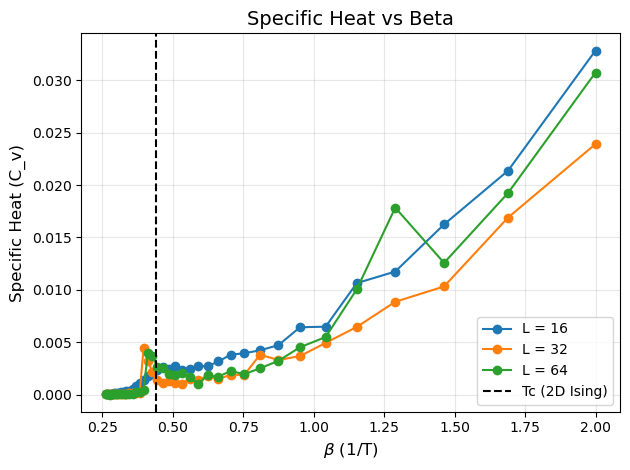

In [72]:
# Specific heat calculation
specific_heat = {}
for L in L_range:
    specific_heat[L] = []
    for T in T_range:
        result = results[L][T]
        energy_history = result['energy_history']
        if len(energy_history) > 10:
            cv = calculate_specific_heat(energy_history, L, T)
        else:
            cv = 0.0
        specific_heat[L].append(cv)

# Plot specific heat vs temperature
#plt.figure(figsize=(10, 6))
beta_range = 1/T_range
for L in L_range[1:]:
    plt.plot(beta_range[:-13], specific_heat[L][:-13], marker='o', label=f'L = {L}')

plt.axvline(x=1/2.269, color='k', linestyle='--', label='Tc (2D Ising)')
plt.xlabel(r'$\beta$ (1/T)', fontsize=12)
plt.ylabel('Specific Heat (C_v)', fontsize=12)
plt.title('Specific Heat vs Beta', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Time Series

In [172]:
def specific_heat_time_series(energy_history, L, T, window_size=10):
    """
    Calculate running specific heat from energy measurements.
    
    Args:
        energy_history (list): List of energy measurements
        L (int): Lattice size
        T (float): Temperature
        window_size (int): Number of samples per calculation
        
    Returns:
        tuple: (specific_heat_series, tau_list) where:
            - specific_heat_series: List of C_v values
            - tau_list: Corresponding time indices
    """
    specific_heat = []
    t_list = []
    
    for t in range(window_size, len(energy_history), window_size//2):  # 50% overlapping windows
        window = energy_history[t-window_size:t]
            
        # Calculate fluctuations in this window
        mean_e = np.mean(window)
        mean_e2 = np.mean([e*e for e in window])
        C_v = (mean_e2 - mean_e**2) / (T**2 * L**2)  # Per-site specific heat
        
        specific_heat.append(C_v)
        t_list.append(t)
    
    return specific_heat, t_list

In [174]:
T_range

array([0.5       , 0.59183673, 0.68367347, 0.7755102 , 0.86734694,
       0.95918367, 1.05102041, 1.14285714, 1.23469388, 1.32653061,
       1.41836735, 1.51020408, 1.60204082, 1.69387755, 1.78571429,
       1.87755102, 1.96938776, 2.06122449, 2.15306122, 2.24489796,
       2.33673469, 2.42857143, 2.52040816, 2.6122449 , 2.70408163,
       2.79591837, 2.8877551 , 2.97959184, 3.07142857, 3.16326531,
       3.25510204, 3.34693878, 3.43877551, 3.53061224, 3.62244898,
       3.71428571, 3.80612245, 3.89795918, 3.98979592, 4.08163265,
       4.17346939, 4.26530612, 4.35714286, 4.44897959, 4.54081633,
       4.63265306, 4.7244898 , 4.81632653, 4.90816327, 5.        ])

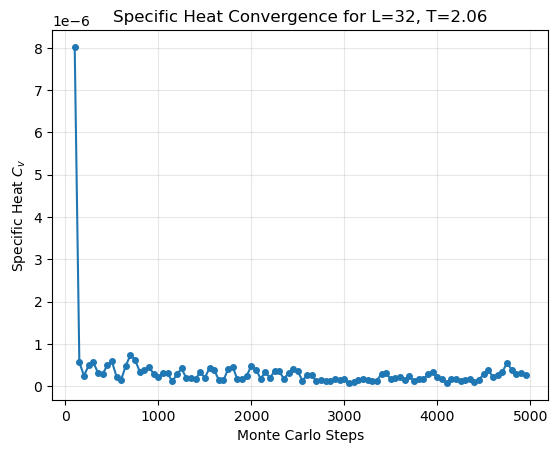

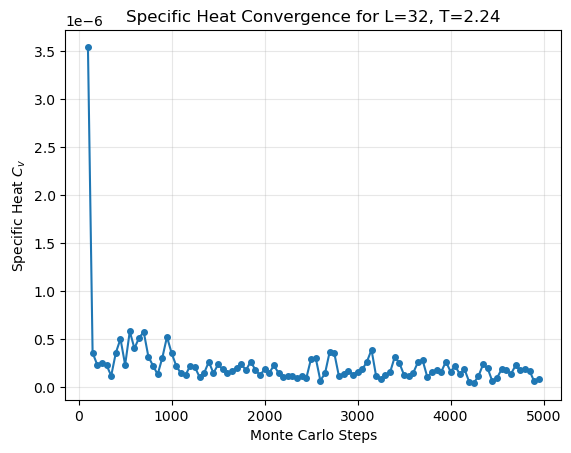

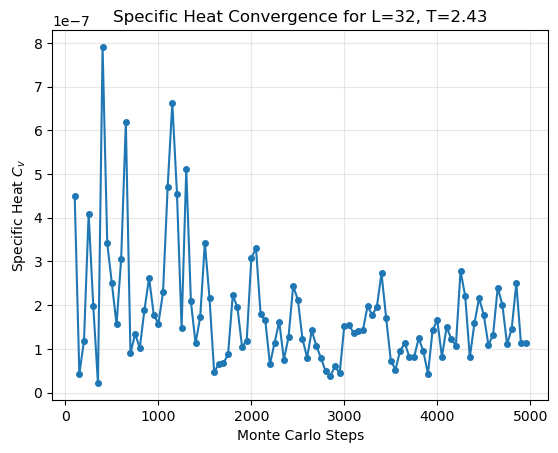

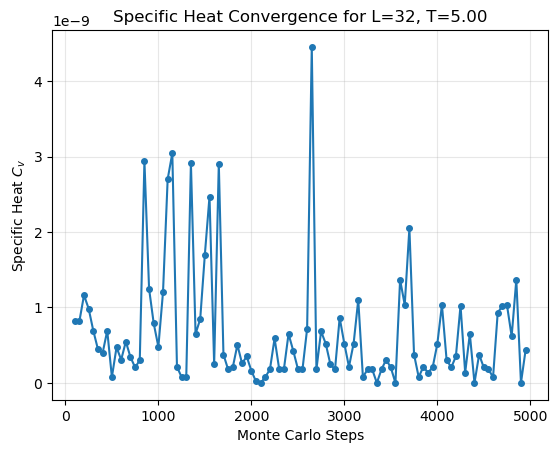

In [186]:
# Get energy history from your simulation results
L=32
Temp=[T_range[17], T_range[19], T_range[21], T_range[-1]]

for T in Temp:
    energy_history = results[L][T]['energy_history']
    
    # Calculate time series
    Cv_series, time_points = specific_heat_time_series(energy_history, L, T)
    time_points = [t * 10 for t in time_points] 
    # Plot evolution
    plt.plot(time_points, Cv_series, '-o', label=f'T = {T}', markersize=4)
    plt.xlabel('Monte Carlo Steps')
    plt.ylabel('Specific Heat $C_v$')
    plt.title(f'Specific Heat Convergence for L={L}, T={T:.2f}')
    plt.grid(alpha=0.3)
    plt.show()

### Finte Size Scaling

In [190]:
L_range_2 = [16, 32, 48, 64, 80]
T_range_2 = np.linspace(2.0, 3.0, 20)
# Run simulations for different lattice sizes and temperatures
results_2 = {}

for L in L_range_2:
    results_2[L] = {}
    for T in tqdm(T_range_2, desc=f"L = {L}"):
        result = run_worm_algorithm(L, T, n_worms, steps_per_worm)        
        results_2[L][T] = result

# Specific heat calculation
specific_heat_2 = {}
T_peak = []
for L in L_range_2:
    specific_heat_2[L] = []
    for T in T_range_2:
        result = results_2[L][T]
        energy_history = result['energy_history']
        if len(energy_history) > 10:
            cv = calculate_specific_heat(energy_history, L, T)
        else:
            cv = 0.0
        specific_heat_2[L].append(cv)
    T_peak.append(T_range_2[np.argmax(specific_heat_2[L])])

L = 16:   0%|          | 0/20 [00:00<?, ?it/s]

L = 80: 100%|██████████| 20/20 [14:48<00:00, 44.41s/it]


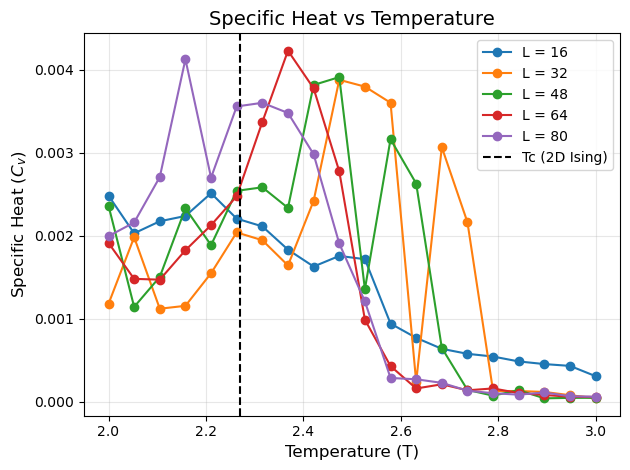

In [191]:

# Plot specific heat vs temperature
#plt.figure(figsize=(10, 6))
beta_range = 1/T_range_2
for L in L_range_2:
    plt.plot(T_range_2, specific_heat_2[L], marker='o', label=f'L = {L}')

plt.axvline(x=2.269, color='k', linestyle='--', label='Tc (2D Ising)')
plt.xlabel('Temperature (T)', fontsize=12)
plt.ylabel(r'Specific Heat ($C_v$)', fontsize=12)
plt.title('Specific Heat vs Temperature', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

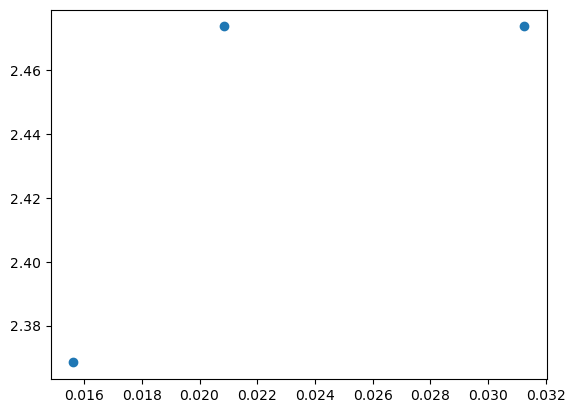

In [197]:
inv_L = 1/np.array(L_range_2[1:-1])
plt.plot(inv_L, T_peak[1:-1], 'o')

### Susceptibility

In [159]:
def calculate_susceptibility(normalized_G, L, T):
    """Calculate magnetic susceptibility"""
    return sum(normalized_G.values())/(L**2 * T)

In [160]:
# Susceptibility calculation
susceptibility_results = {}
for L in L_range:
    susceptibility_results[L] = []
    for T in T_range:
        result = results[L][T]
        normalized_G = result['G_r']
        susceptibility = calculate_susceptibility(normalized_G, L, T)
        susceptibility_results[L].append(susceptibility)

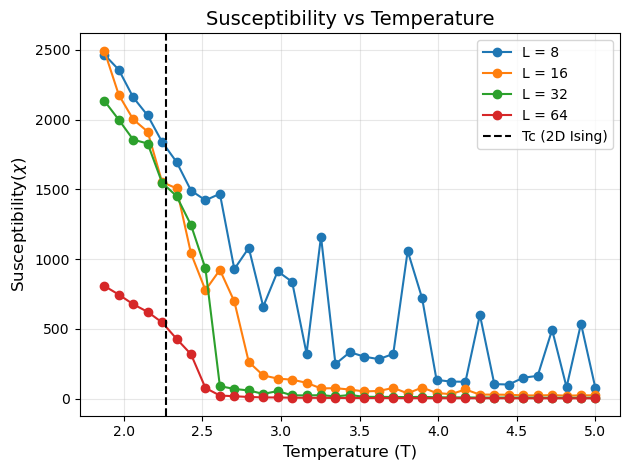

In [161]:
# Plot susceptibility vs temperature
beta_range = 1.0 / T_range
#plt.figure(figsize=(10, 6))
for L in L_range:
    plt.plot(T_range[15:], susceptibility_results[L][15:], marker='o', label=f'L = {L}')
plt.axvline(x=2.269, color='k', linestyle='--', label='Tc (2D Ising)')
plt.xlabel('Temperature (T)', fontsize=12)
plt.ylabel(r'Susceptibility($\chi$)', fontsize=12)
#plt.yscale('log')
plt.title('Susceptibility vs Temperature', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

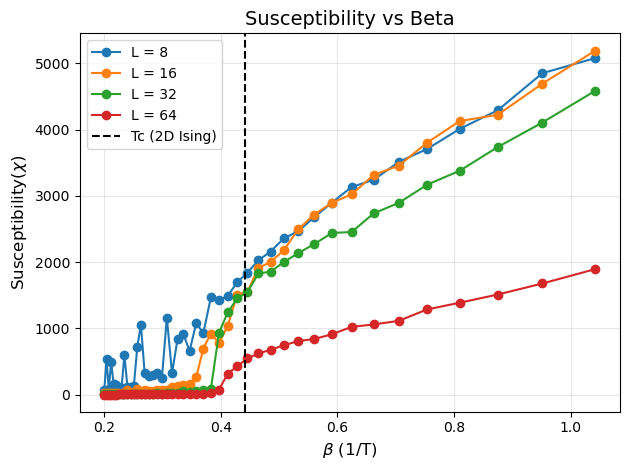

In [162]:
# Plot susceptibility vs temperature
beta_range = 1.0 / T_range
#plt.figure(figsize=(10, 6))
for L in L_range:
    plt.plot(beta_range[5:], susceptibility_results[L][5:], marker='o', label=f'L = {L}')
plt.axvline(x=1/2.269, color='k', linestyle='--', label='Tc (2D Ising)')
plt.xlabel(r'$\beta$ (1/T)', fontsize=12)
plt.ylabel(r'Susceptibility($\chi$)', fontsize=12)
#plt.yscale('log')
plt.title('Susceptibility vs Beta', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [163]:
def calculate_susceptibility(normalized_G, L, T):
    """Calculate magnetic susceptibility"""
    return sum(normalized_G.values())/(L**2)

In [164]:
# Susceptibility calculation
susceptibility_results = {}
for L in L_range:
    susceptibility_results[L] = []
    for T in T_range:
        result = results[L][T]
        normalized_G = result['G_r']
        susceptibility = calculate_susceptibility(normalized_G, L, T)
        susceptibility_results[L].append(susceptibility)

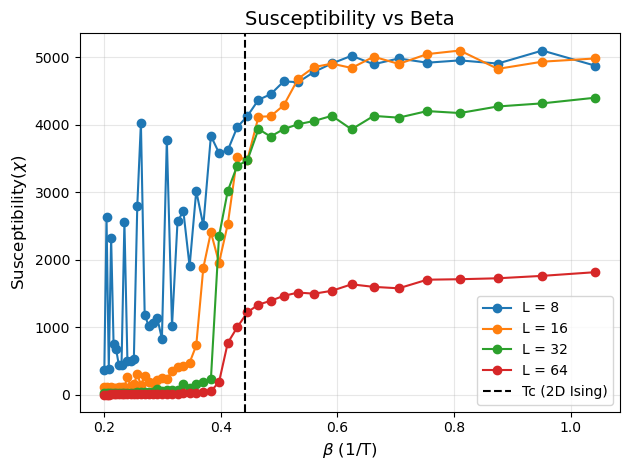

In [165]:
# Plot susceptibility vs temperature
beta_range = 1.0 / T_range
#plt.figure(figsize=(10, 6))
for L in L_range:
    plt.plot(beta_range[5:], susceptibility_results[L][5:], marker='o', label=f'L = {L}')
plt.axvline(x=1/2.269, color='k', linestyle='--', label='Tc (2D Ising)')
plt.xlabel(r'$\beta$ (1/T)', fontsize=12)
plt.ylabel(r'Susceptibility($\chi$)', fontsize=12)
#plt.yscale('log')
plt.title('Susceptibility vs Beta', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Magnetization

In [170]:

def calculate_magnetization(path_history, L):
    """Estimate magnetization from worm paths"""
    if not path_history:
        return 0.0
    closed_loops = sum(1 for path in path_history if path[0] == path[-1])
    return closed_loops / len(path_history)

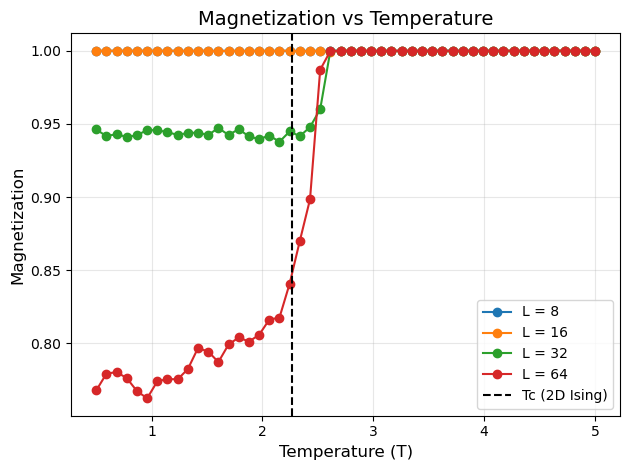

In [188]:
# Magnetization calculation
magnetization_results = {}
for L in L_range:
    magnetization_results[L] = []
    for T in T_range:
        result = results[L][T]
        magnetization = calculate_magnetization(result['path_history'], L)
        magnetization_results[L].append(magnetization)

# Plot magnetization vs temperature
#plt.figure(figsize=(10, 6))
for L in L_range:
    plt.plot(T_range, magnetization_results[L], marker='o', label=f'L = {L}')
plt.axvline(x=2.269, color='k', linestyle='--', label='Tc (2D Ising)')
plt.xlabel('Temperature (T)', fontsize=12)
plt.ylabel('Magnetization', fontsize=12)
plt.title('Magnetization vs Temperature', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Visualization

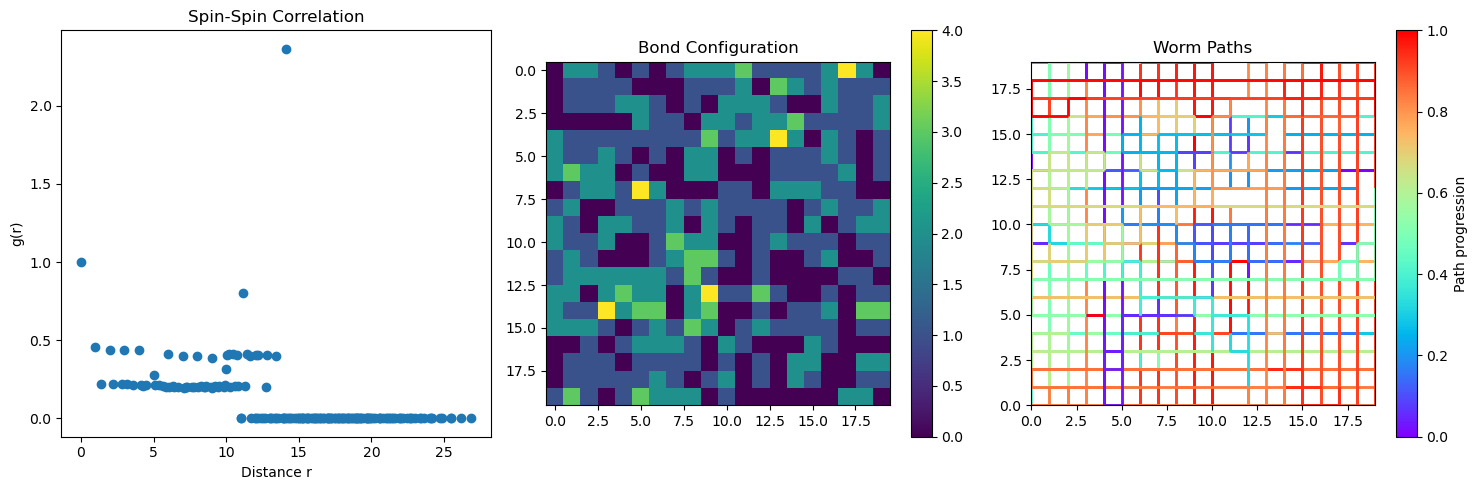

In [85]:
def visualize_results(L, G_r, bonds, paths):
    """Create diagnostic plots"""
    plt.figure(figsize=(15, 5))
    
    # 1. Correlation function
    plt.subplot(131)
    if any(v > 0 for v in G_r.values()):  # Only plot if we have data
        r_vals = [math.sqrt(r2) for r2 in sorted(G_r.keys())]
        g_vals = [G_r[r2] for r2 in sorted(G_r.keys())]
        plt.plot(r_vals, g_vals, 'o')
    plt.xlabel('Distance r')
    plt.ylabel('g(r)')
    plt.title('Spin-Spin Correlation')
    
    # 2. Bond configuration
    plt.subplot(132)
    bond_image = np.sum(bonds, axis=2)  # Sum bonds per site
    plt.imshow(bond_image, cmap='viridis')
    plt.title('Bond Configuration')
    plt.colorbar()
    
    # 3. Worm paths (plot up to last 5 worms)
    plt.subplot(133)
    paths_to_plot = paths[-5:] if len(paths) >= 5 else paths
    for path in paths_to_plot:
        x, y = zip(*path)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='rainbow', linewidths=2)
        lc.set_array(np.linspace(0, 1, len(path)-1))
        plt.gca().add_collection(lc)
    plt.xlim(0, L-1)
    plt.ylim(0, L-1)
    plt.gca().set_aspect('equal')
    plt.title('Worm Paths')
    if paths_to_plot:  # Only add colorbar if we have paths
        plt.colorbar(lc, label='Path progression')
    
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_results(L, G_r, bonds, paths)

### Step by step visualization

In [132]:
def show_worm_frames_with_bonds(path, bonds_history, L, pause=0.5):
    import matplotlib.pyplot as plt
    from matplotlib.collections import LineCollection
    
    for step in range(len(path)):
        plt.figure(figsize=(5, 5))
        
        # Current worm path up to this step
        xs, ys = zip(*path[:step+1])
        plt.plot(xs, ys, 'o-', color='blue', alpha=0.7, linewidth=2, markersize=8, label='Worm Path')
        
        # Highlight start and current position
        plt.plot(path[0][0], path[0][1], 'o', color='limegreen', markersize=12, label='Start')
        plt.plot(xs[-1], ys[-1], 'o', color='red', markersize=12, label=f'Current (Step {step})')
        
        # Draw all active bonds (from bonds_history)
        bond_segments = []
        current_bonds = bonds_history[step]
        for x in range(L):
            for y in range(L):
                # Right bond (0)
                if current_bonds[x, y, 0]:
                    bond_segments.append([(x, y), (x, (y+1)%L)])
                # Up bond (2)
                if current_bonds[x, y, 2]:
                    bond_segments.append([(x, y), ((x+1)%L, y)])
        
        lc = LineCollection(bond_segments, colors='red', linewidths=3, alpha=0.5, label = 'Bonds')
        plt.gca().add_collection(lc)
        
        # Formatting
        plt.xlim(-1, L)
        plt.ylim(-1, L)
        plt.xticks(range(L))
        plt.yticks(range(L))
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.gca().set_aspect('equal')
        plt.title(f"Step {step}: {'CLOSED' if step==len(path)-1 else 'Open'}")
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()
        
        if pause and step < len(path)-1:
            import time
            time.sleep(pause)

            
def visual_worm_algorithm_with_history(L, T, max_steps=100):
    beta = 1.0 / T
    bonds = np.zeros((L, L, 4), dtype=int)
    I = [random.randint(0, L-1), random.randint(0, L-1)]
    M = I.copy()
    path = [tuple(I)]
    bonds_history = [bonds.copy()]
    
    for _ in range(max_steps):
        # Choose a direction
        dir_index = random.randint(0, 3)
        dx, dy = DIRECTIONS[dir_index]
        x_new, y_new = (M[0] + dx) % L, (M[1] + dy) % L
        opp_dir = get_opposite_dir(dir_index)
        
        # Determine bond change
        bond_current = bonds[M[0], M[1], dir_index]
        bond_change = 1 if bond_current == 0 else -1  # 1 = add bond, -1 = remove bond

        # Compute acceptance probability
        if bond_change == 1:
            p_accept = math.tanh(beta)
        else:
            p_accept = 1.0  # always accept removal
        
        if random.random() < p_accept:
            # Flip bonds (accepted move)
            bonds[M[0], M[1], dir_index] ^= 1
            bonds[x_new, y_new, opp_dir] ^= 1
            M = [x_new, y_new]
            path.append(tuple(M))
            bonds_history.append(bonds.copy())

            # Check if worm closed
            if M == I and len(path) > 2:
                break
        else:
            # Rejected move, record state anyway for visualization
            bonds_history.append(bonds.copy())
            path.append(tuple(M))  # stay in place
    
    return path, bonds_history


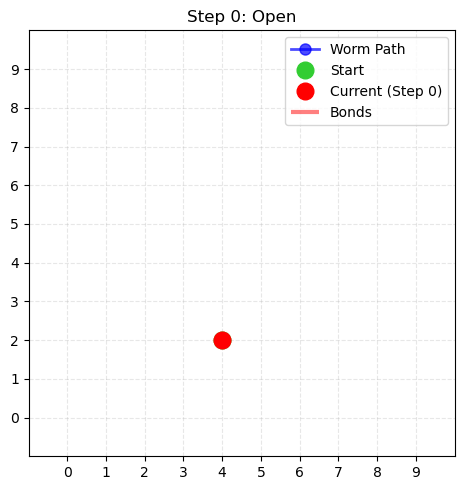

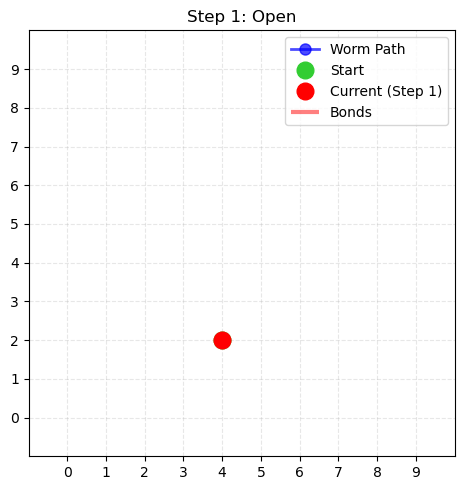

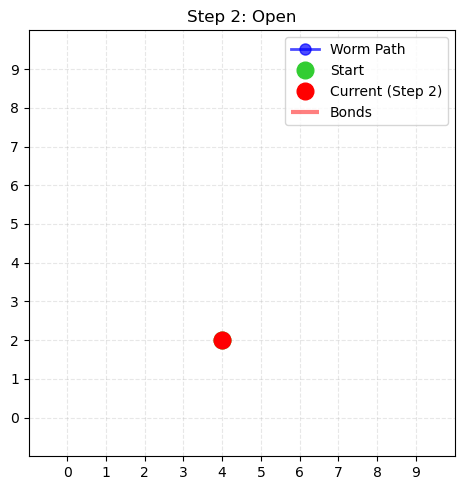

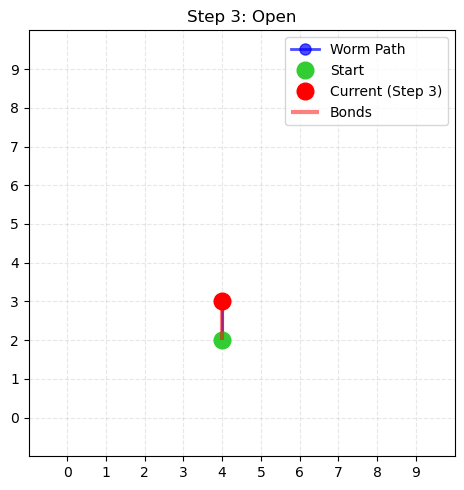

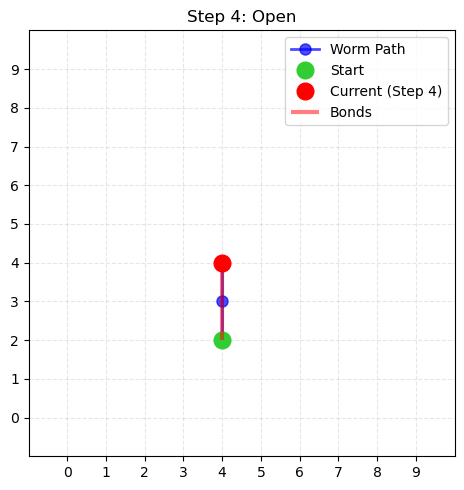

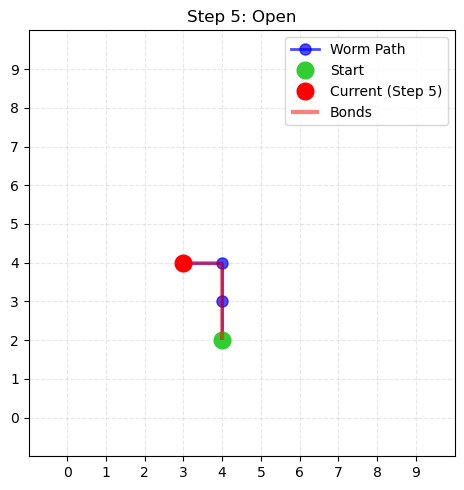

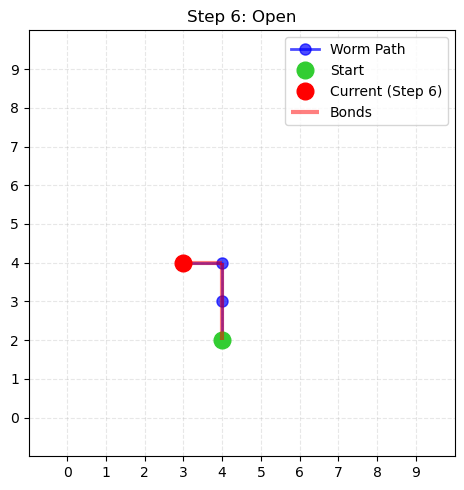

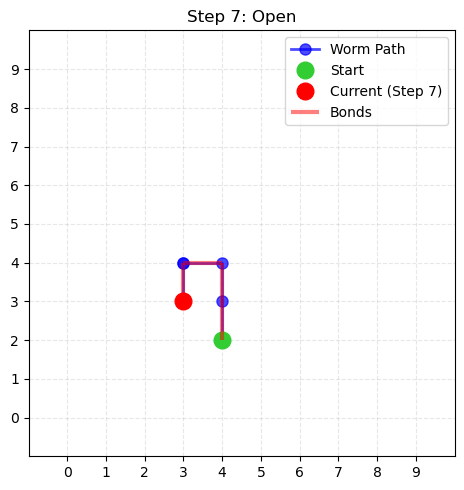

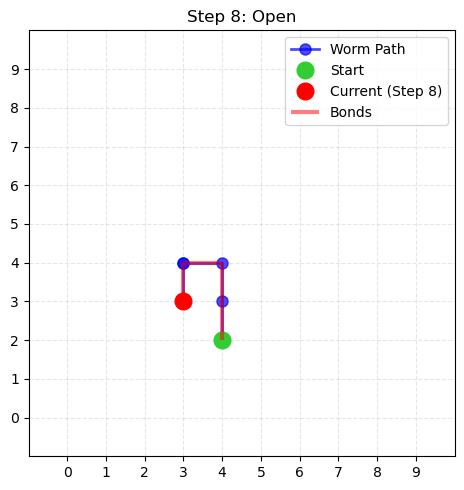

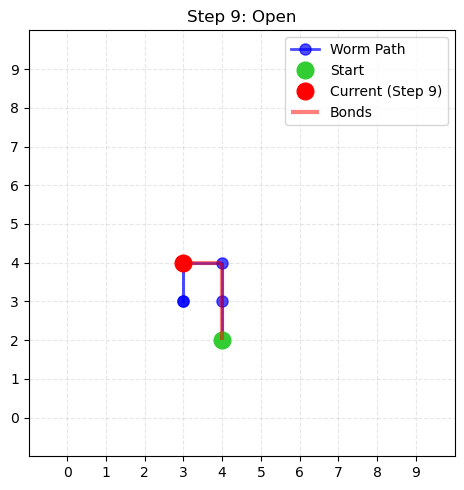

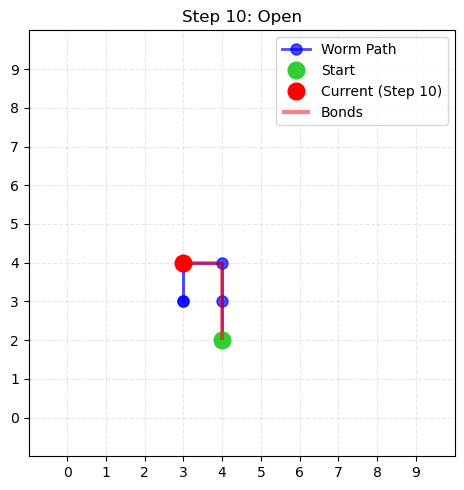

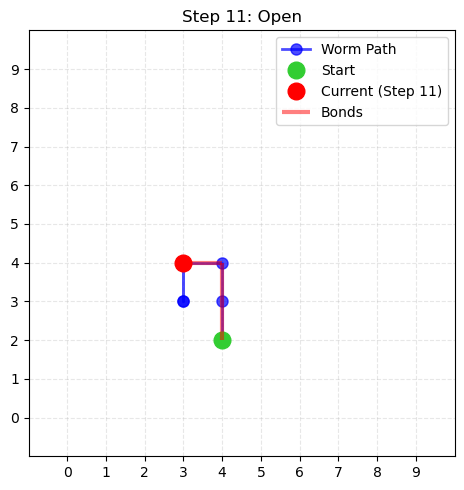

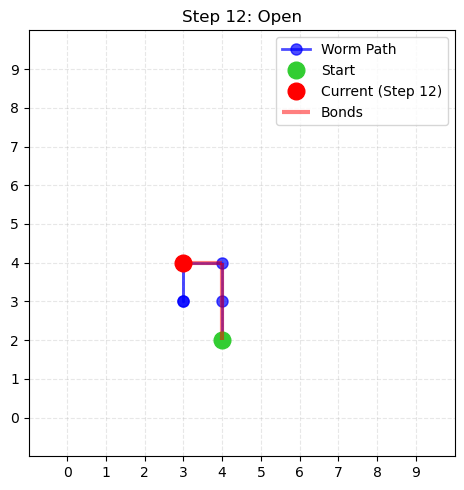

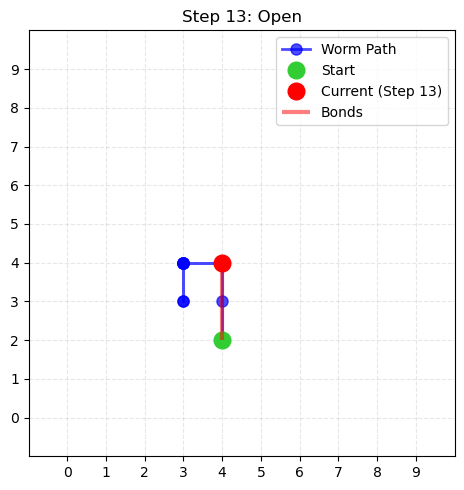

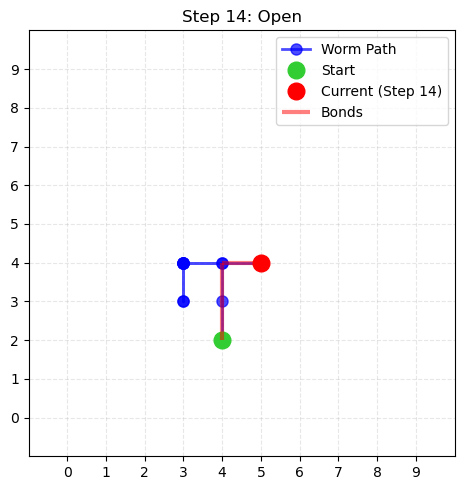

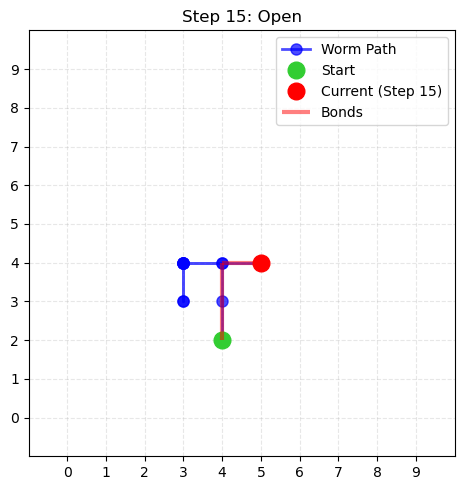

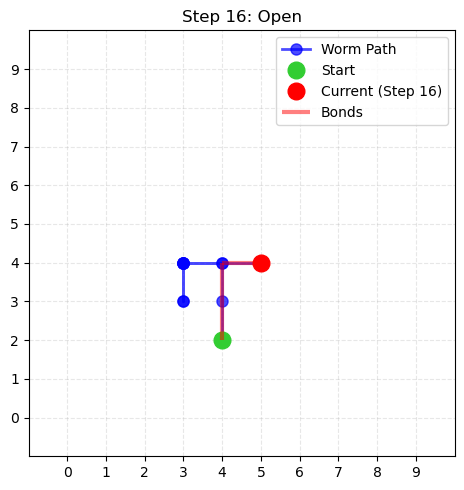

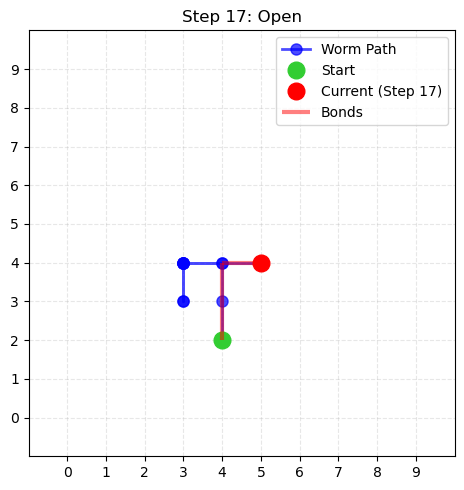

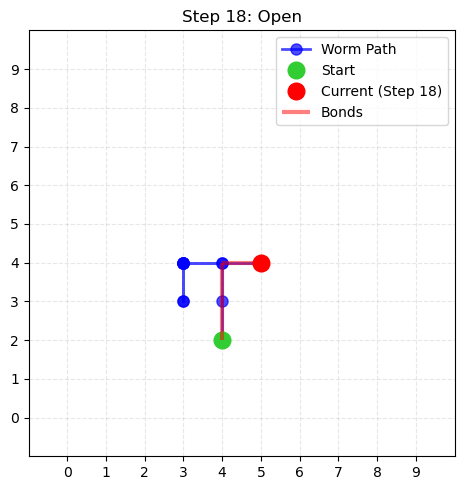

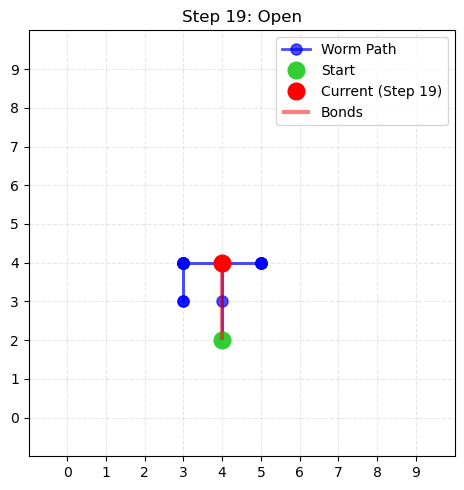

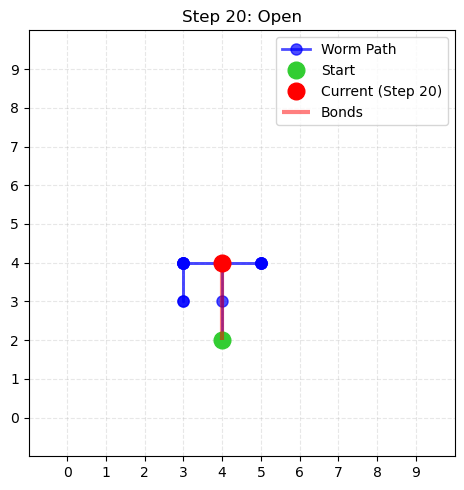

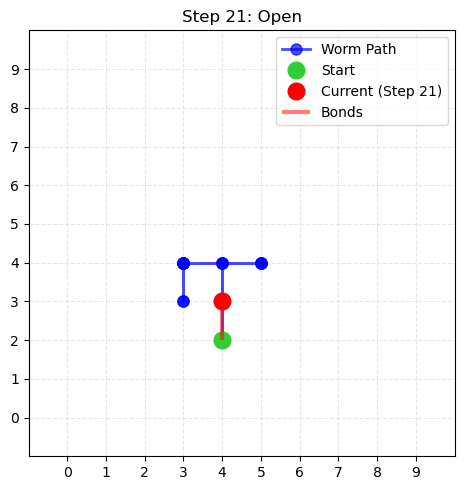

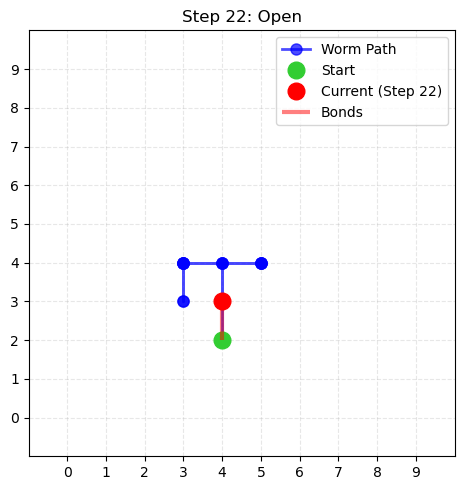

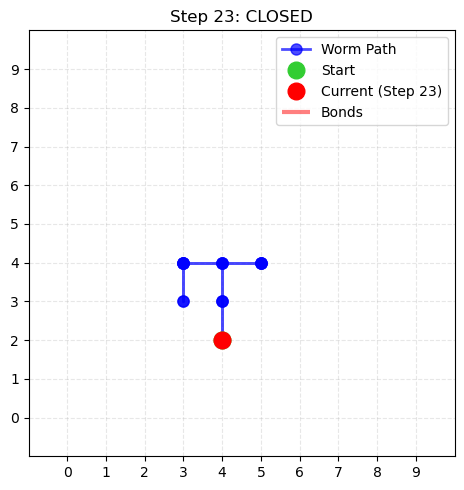

In [135]:
# Generate path and bond history
path, bonds_history = visual_worm_algorithm_with_history(L=10, T=2.27, max_steps=50)

# Visualize step-by-step
show_worm_frames_with_bonds(path, bonds_history, L=10)

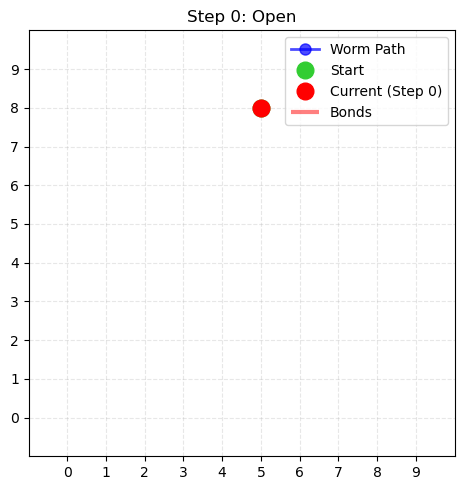

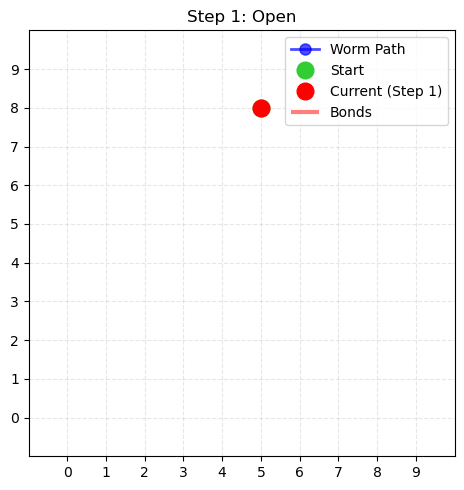

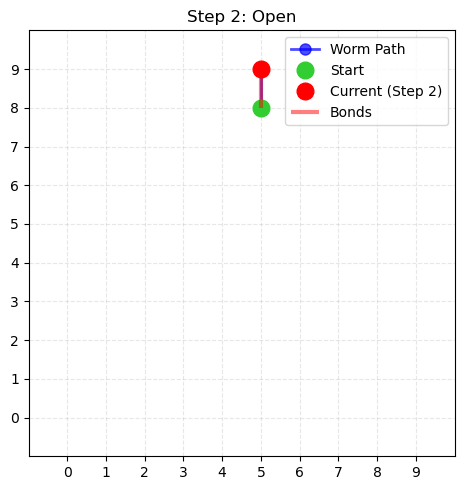

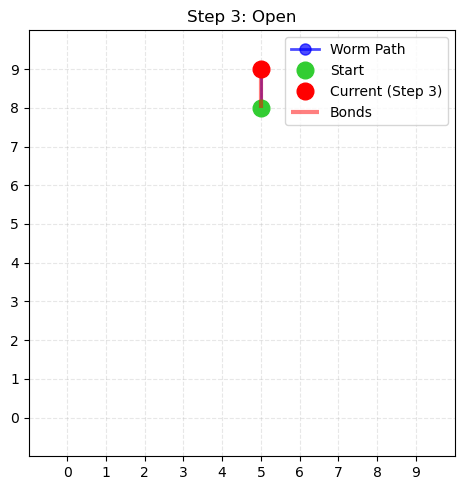

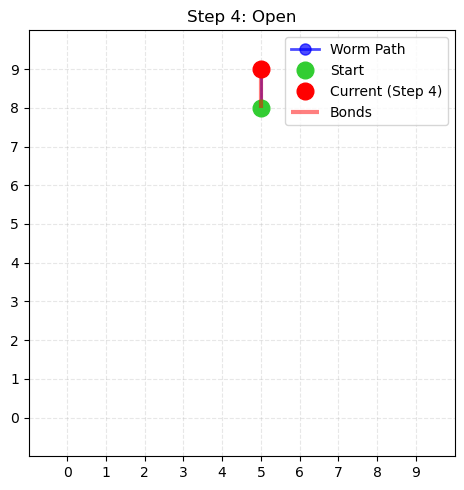

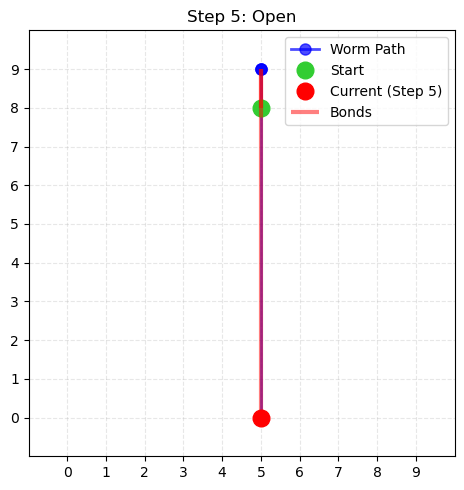

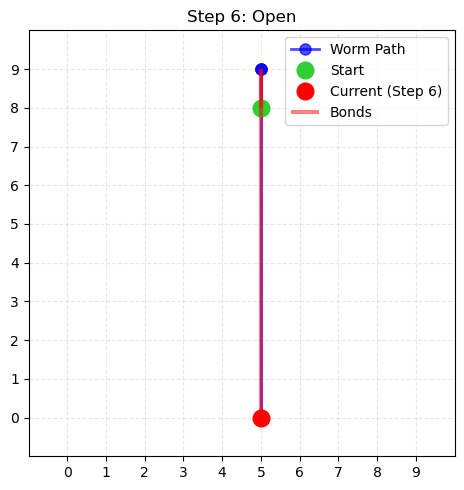

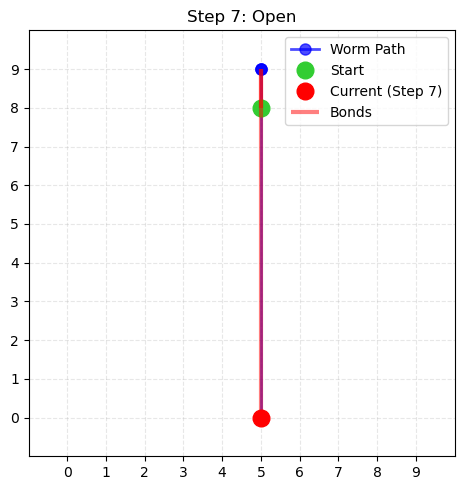

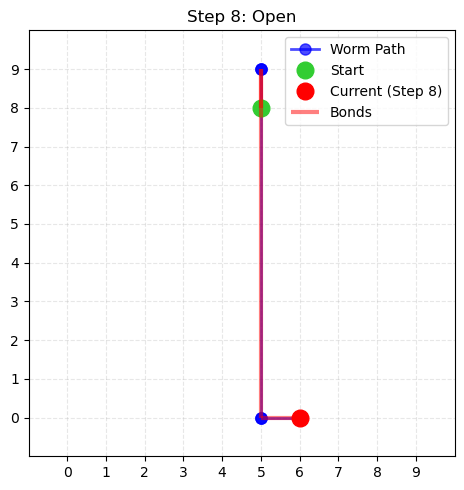

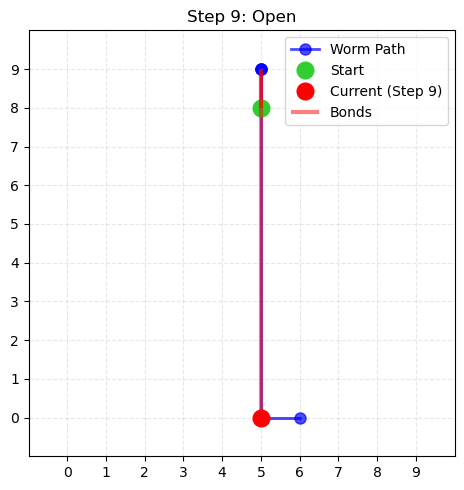

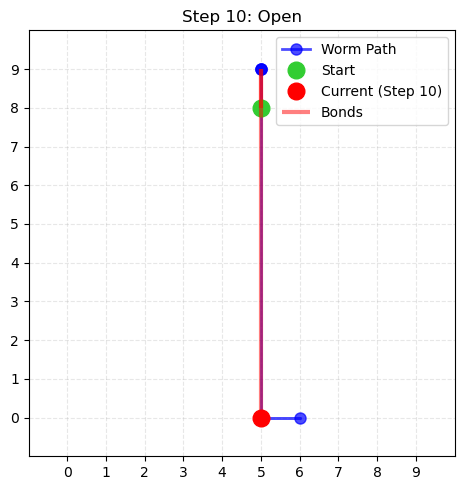

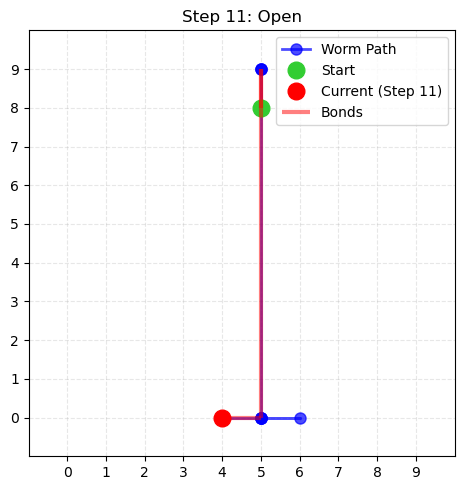

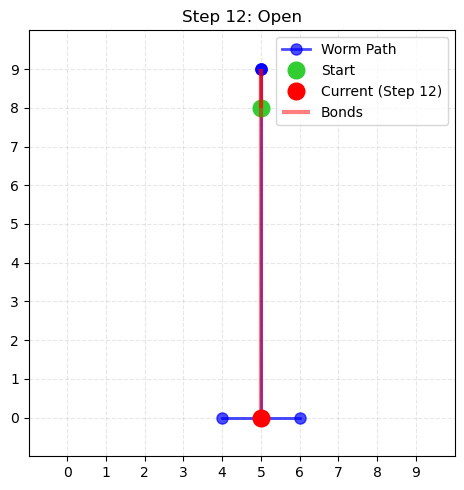

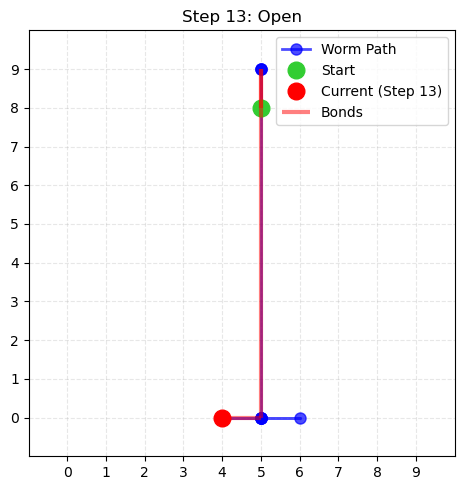

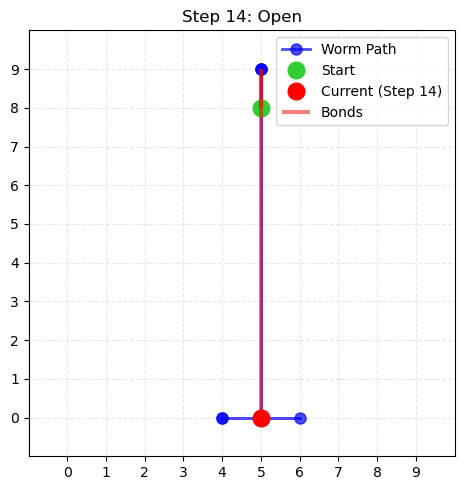

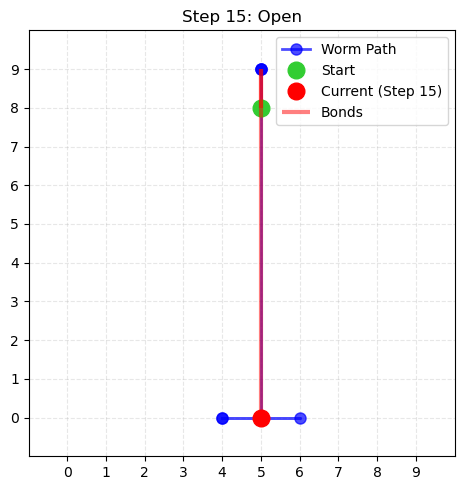

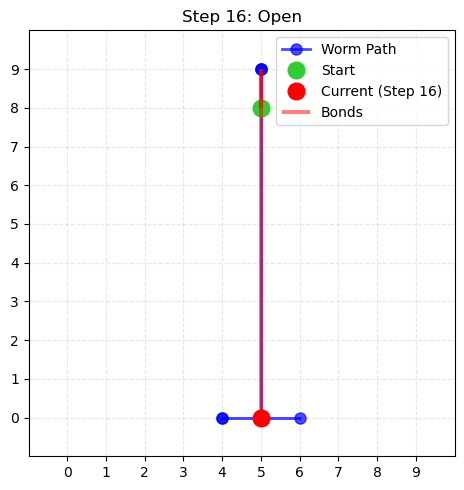

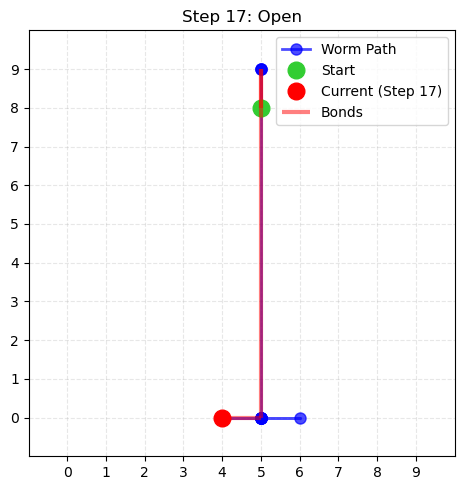

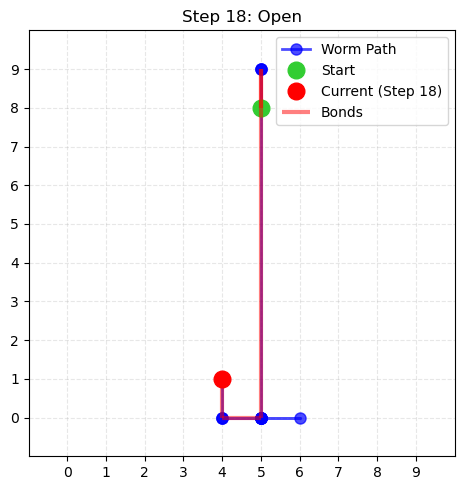

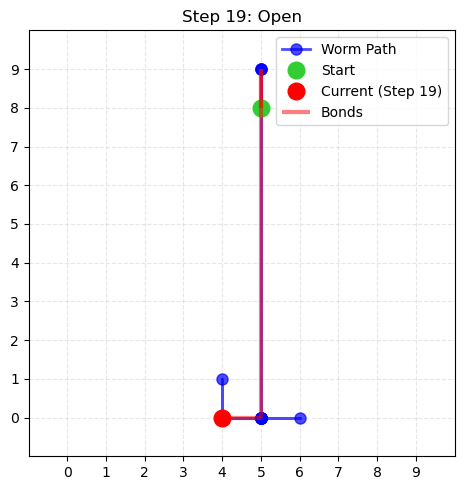

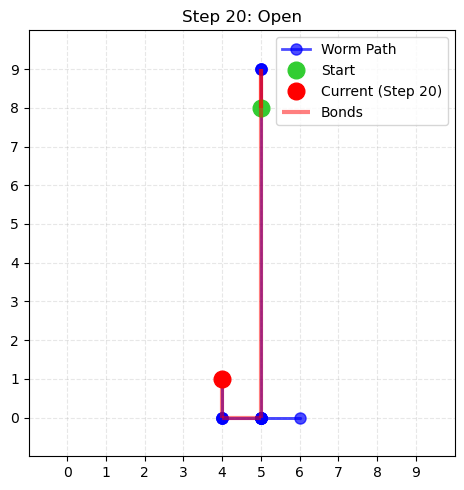

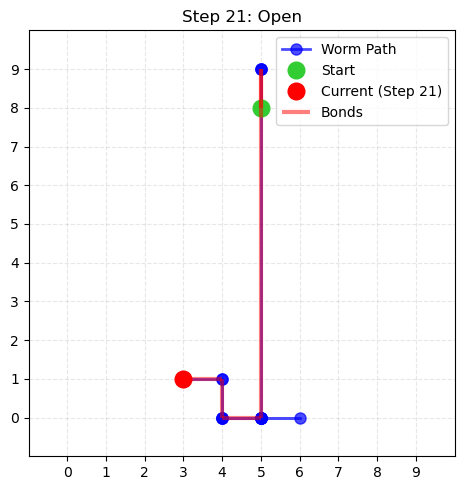

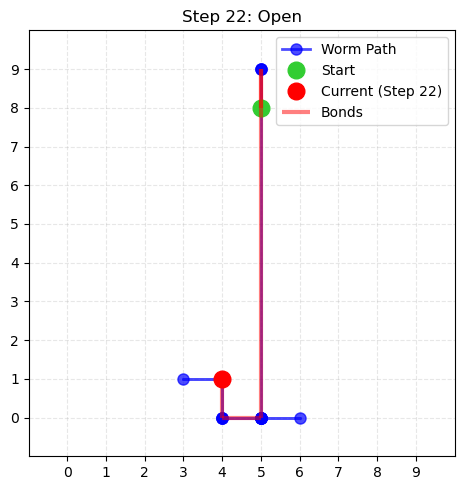

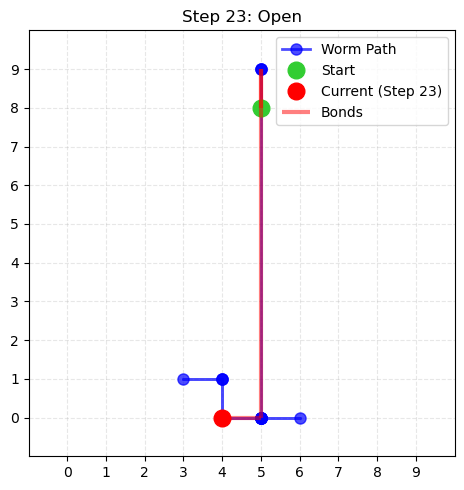

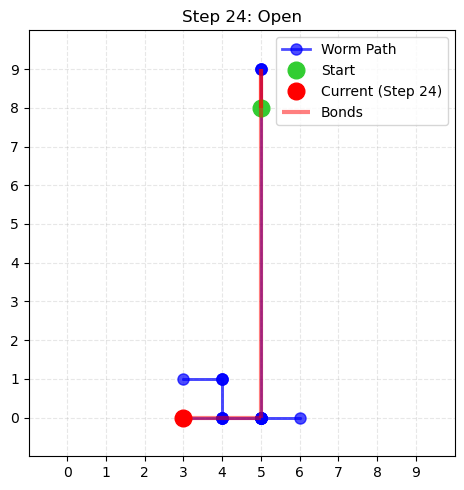

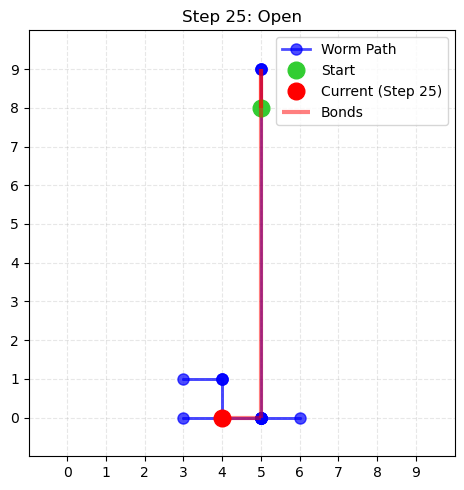

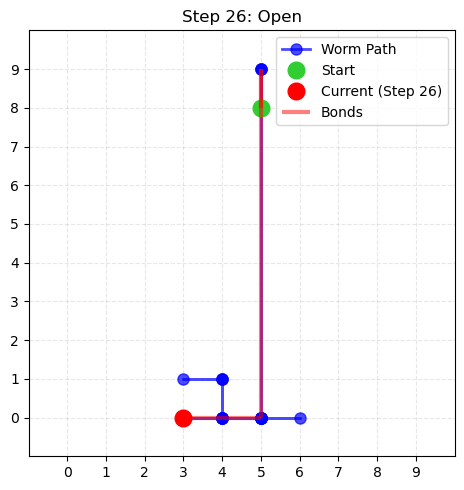

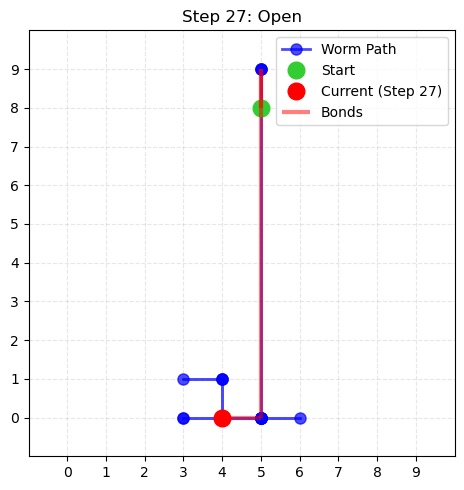

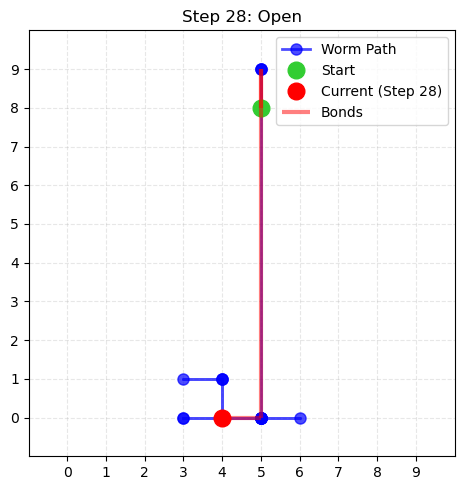

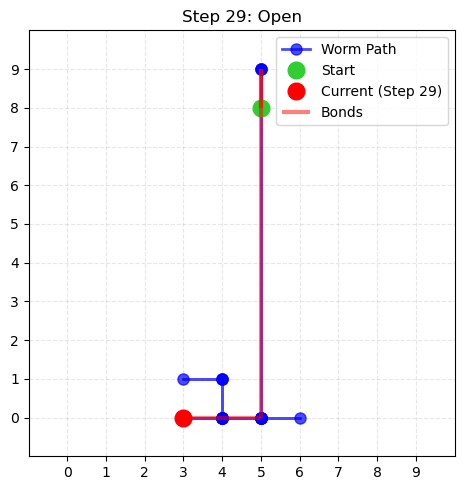

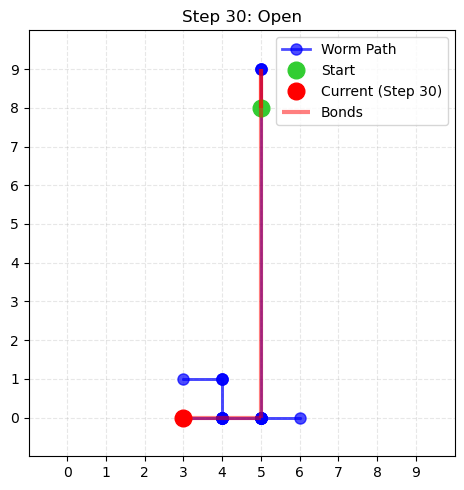

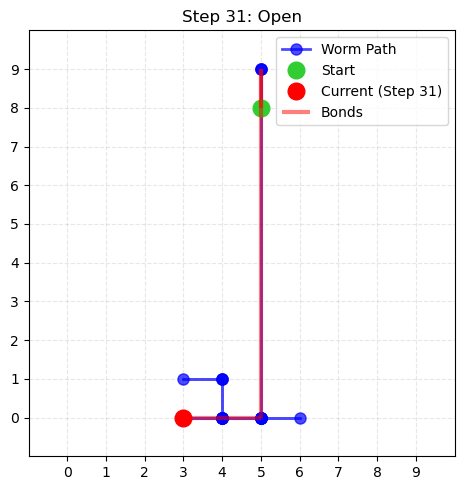

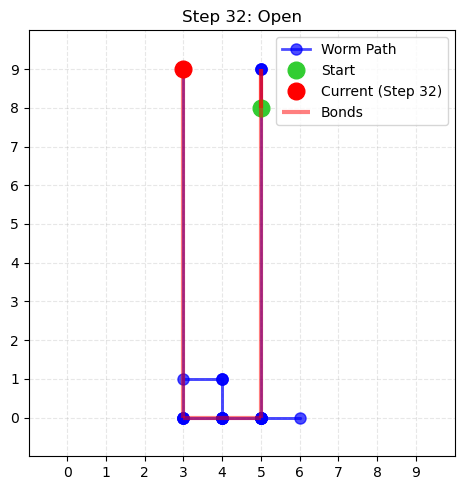

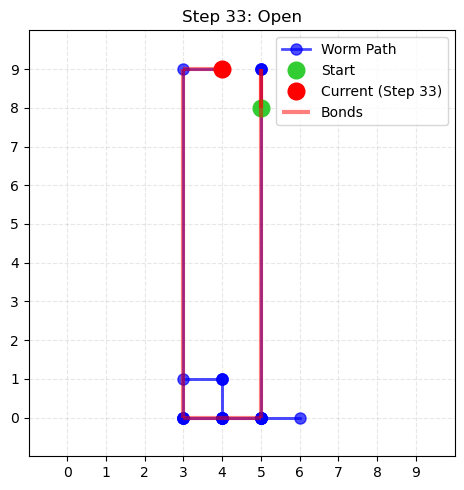

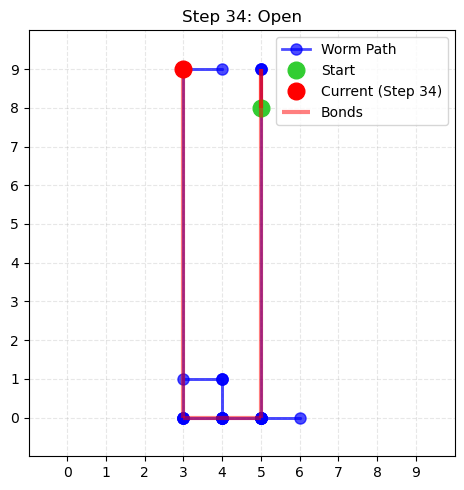

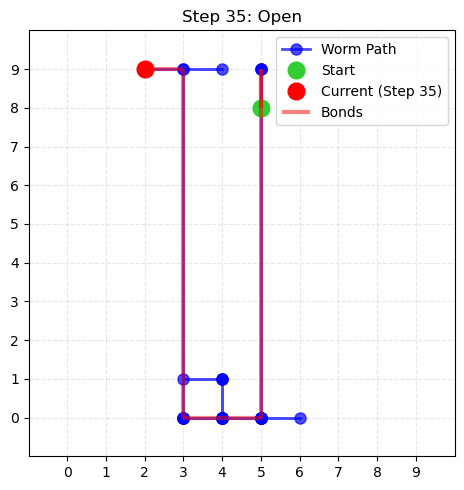

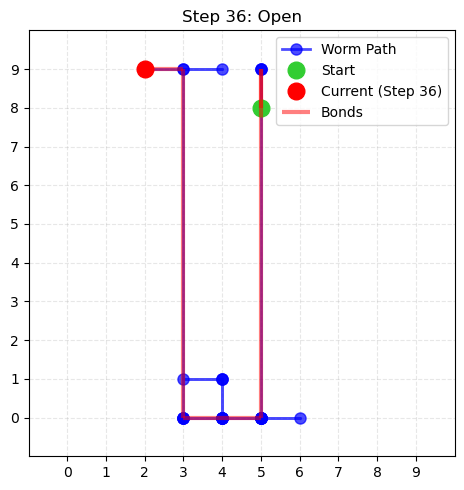

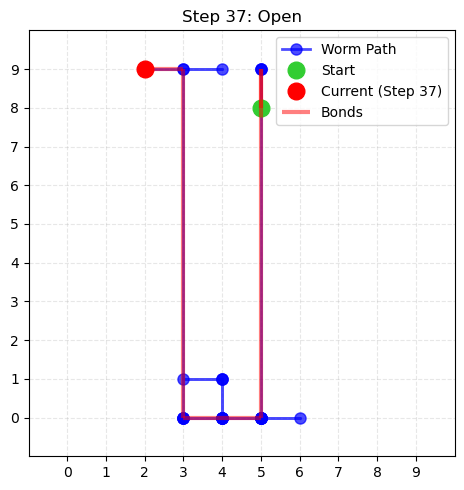

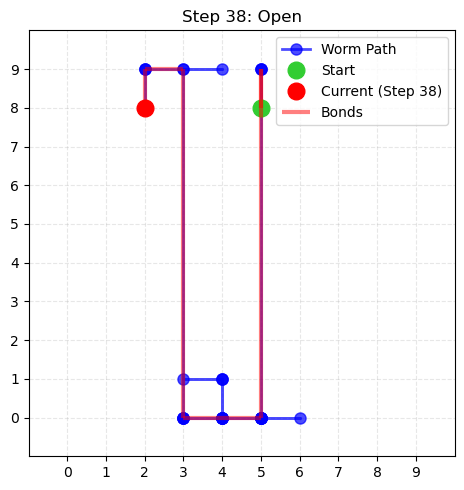

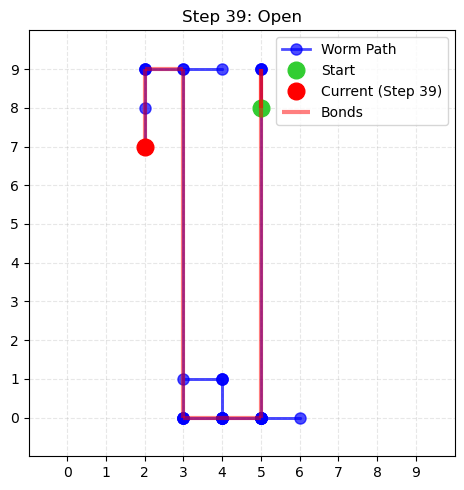

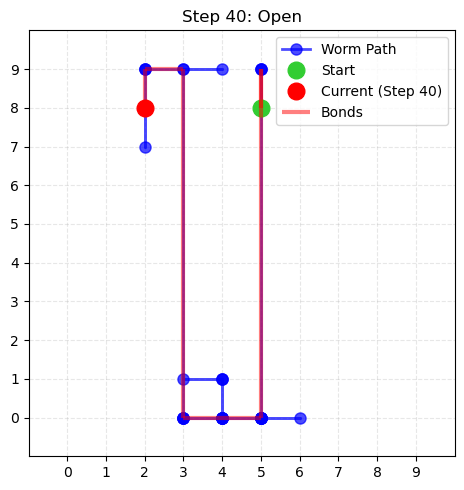

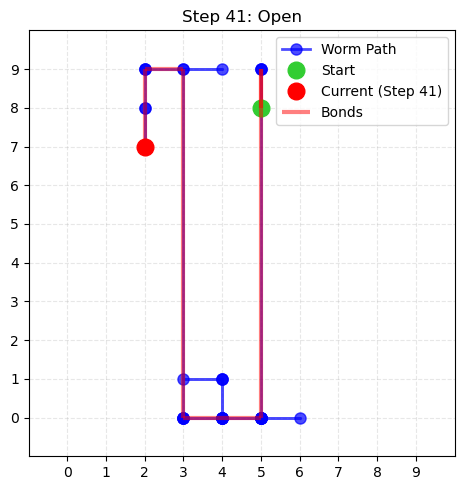

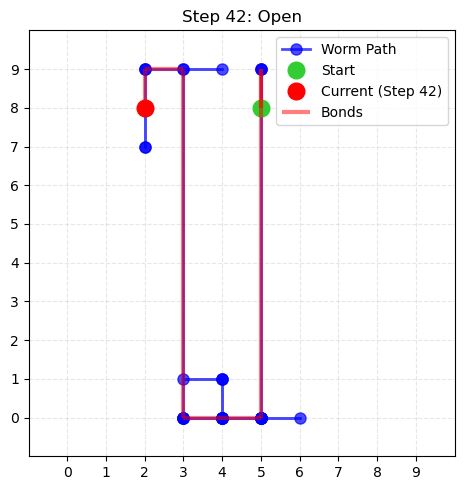

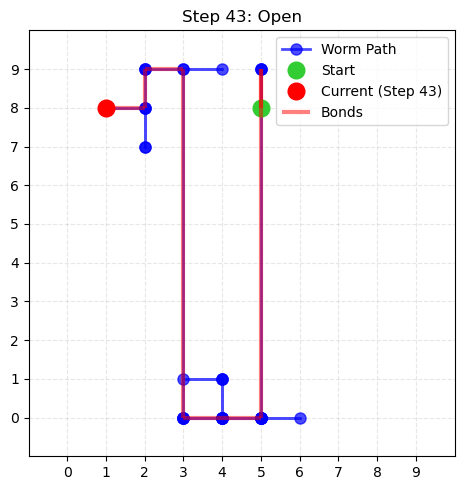

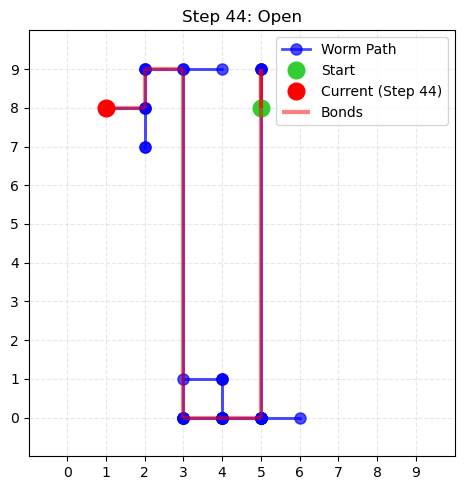

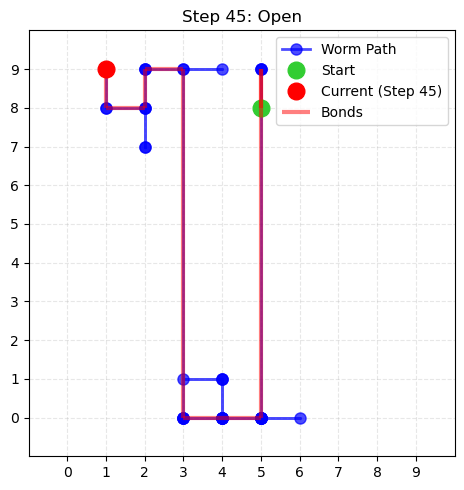

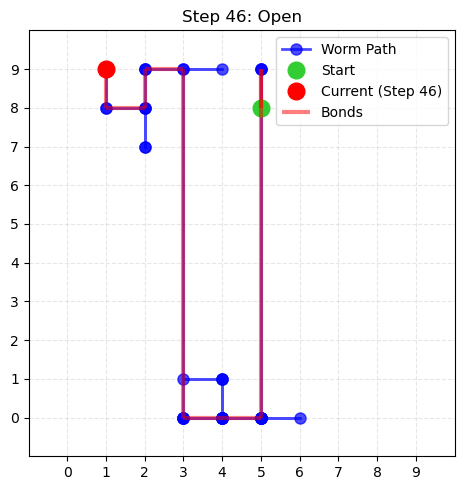

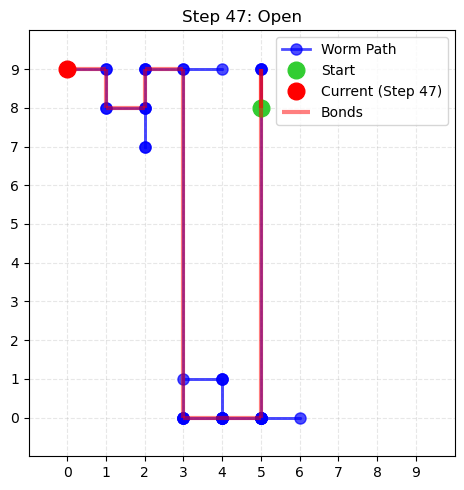

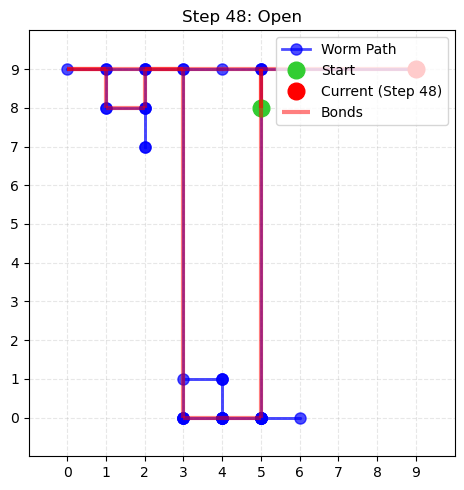

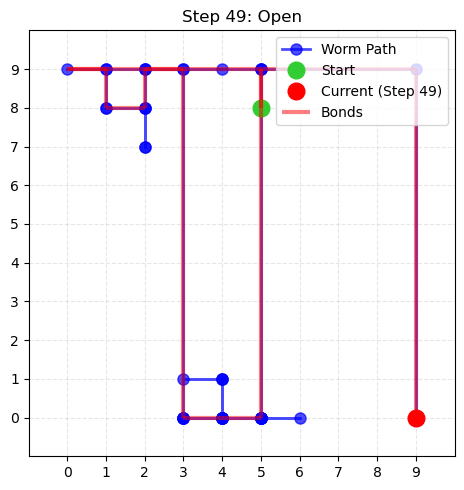

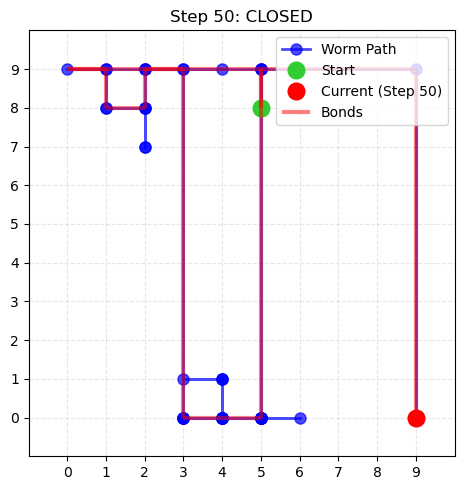

In [139]:
# Generate path and bond history
path, bonds_history = visual_worm_algorithm_with_history(L=10, T=1.5, max_steps=50)

# Visualize step-by-step
show_worm_frames_with_bonds(path, bonds_history, L=10)

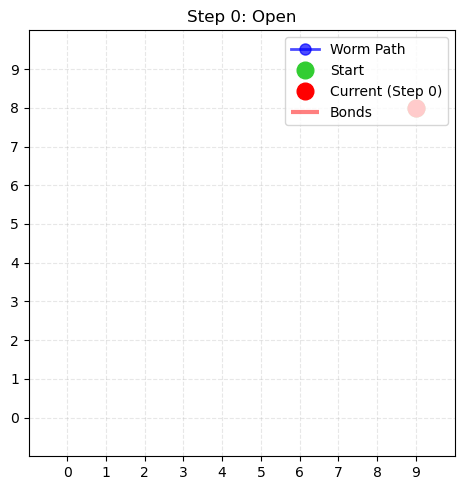

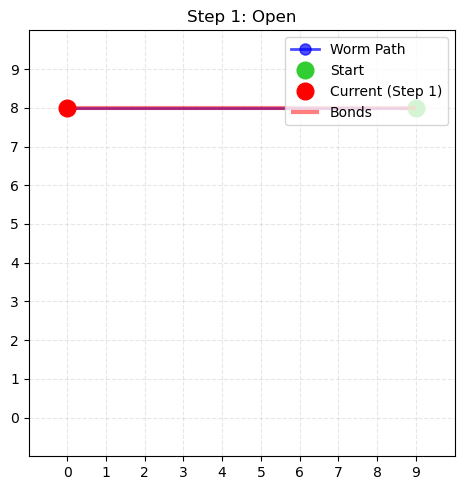

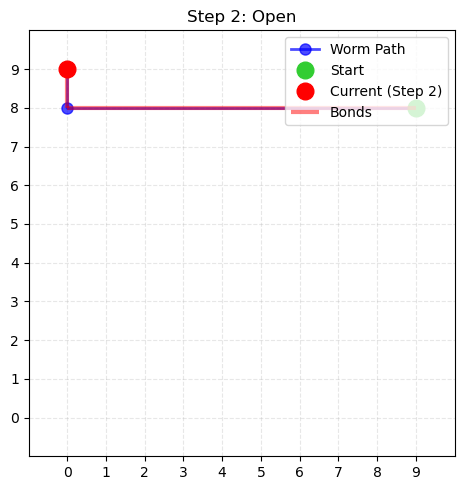

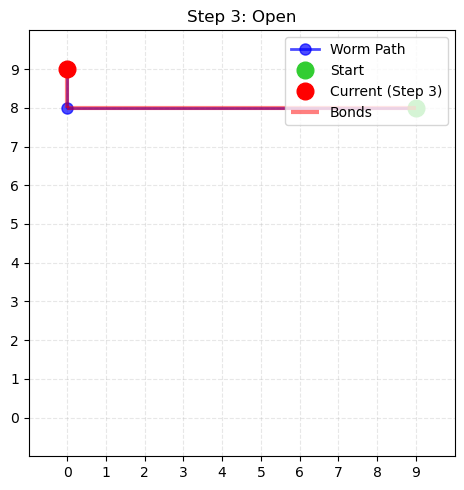

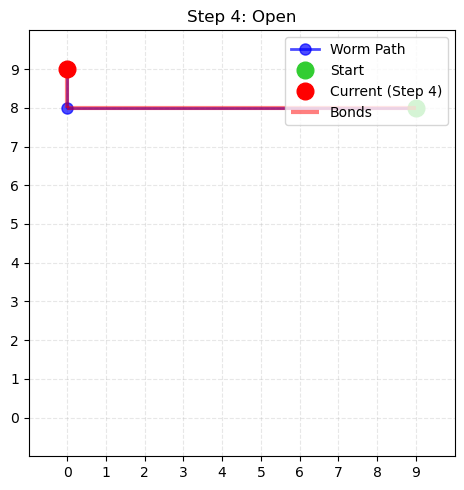

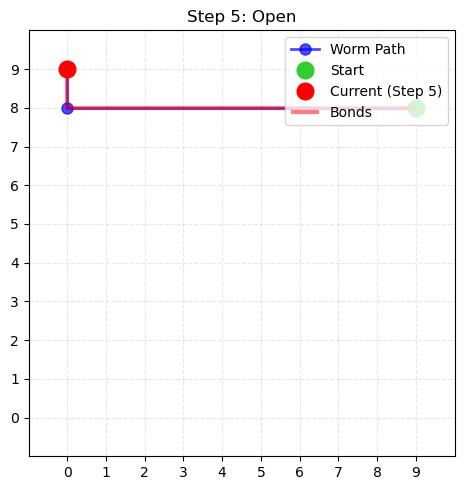

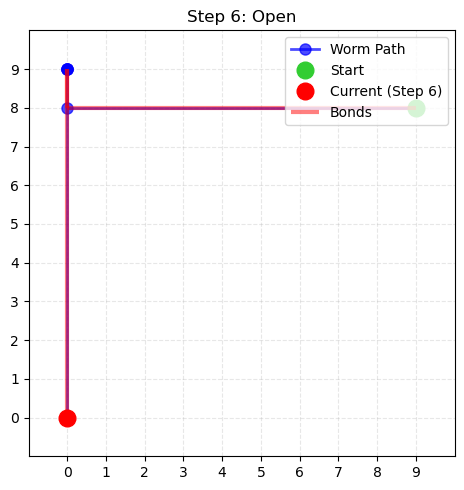

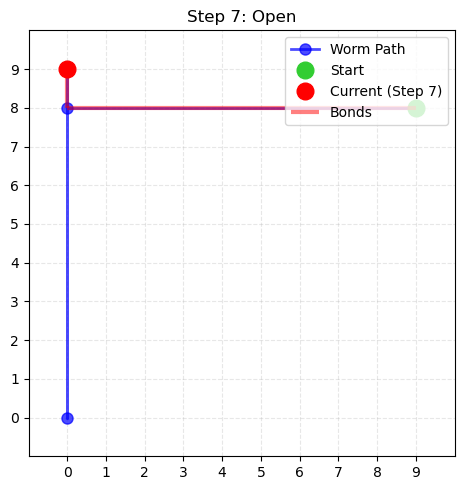

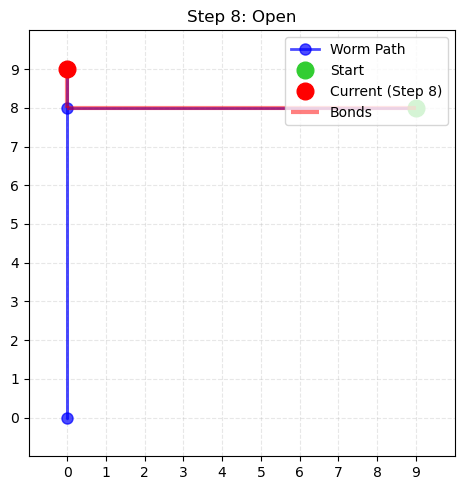

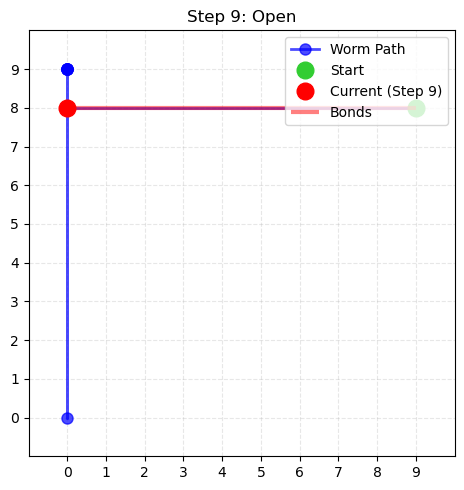

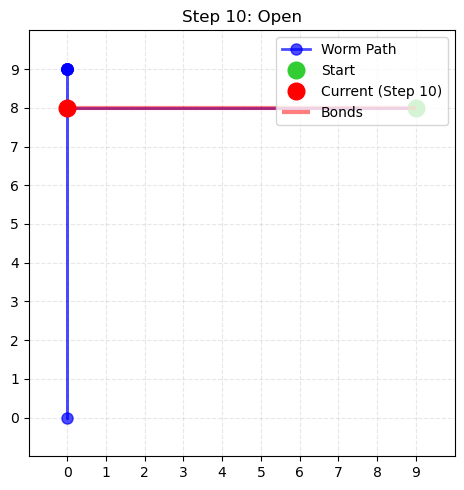

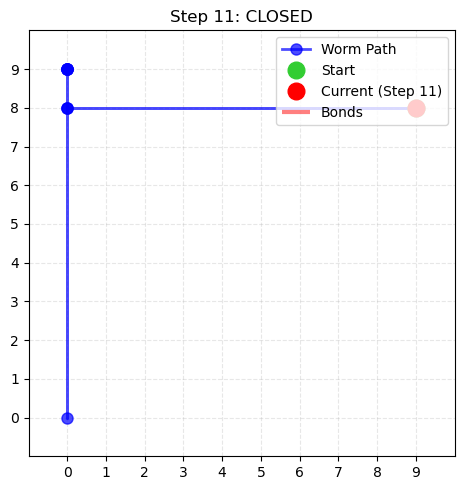

In [144]:
# Generate path and bond history
path, bonds_history = visual_worm_algorithm_with_history(L=10, T=3.0, max_steps=50)

# Visualize step-by-step
show_worm_frames_with_bonds(path, bonds_history, L=10)